# Predicting Numerical Graduation Rate

Based on feedback from our TF on 12/7, we attempted several forms of regression to see how well we could predict numerical graduation rate with school district characteristics alone, then with previous years graduation rates, then with school district characteristics and previous years graduation rates.

One opportunity in this space is that the U.S. Department of Education typically delays making graduation rate data available.  For instance, it is the 2015-2016 school year, and the most current graduation rate data available is for the year 2009-2010.  If we could build a model to predict graduation rate for the years of missing data, organizations that rely on graduation rate data to provide schools services could use this graduation rate approximation until newer graduation rate data becomes available.

For this notebook, we pulled 3 previous years of graduation rate data (2006-2007, 2007-2008, and 2008-2009).  First we built regression models using school district data alone and predicting numerical graduation rate, then we built regression models using historic graduation rate data alone and predicting numerical graduation rate, then we built regression models using school district data and historic graduation rate data and predicting numerical graduation rate, and lastly we built a regression model using 2006-2007 school district data and fed it new 2009-2010 school district data to see how well it would predict 2009-2010 numerical graduation rate.

We compared the models using mean squared error, with the lower the mean squared error, the better.

#Table of Contents
* [1. Linear Regression](#Linear-Regression)<br>
* [2. Lasso Regression](#Lasso-Regression)<br>
* [3. Elastic Net Regression](#Elastic-Net-Regression)<br>
* [4. Predicting graduation based on previous year graduation](#Predicting-graduation-based-on-previous-year-graduation)<br>
    * [1. Linear Regression - 0607, 0708, and 0809](#Linear-Regression---0607,-0708,-and-0809)<br>
    * [2. Linear Regression - 0708 and 0809](#Linear-Regression---0708-and-0809)<br>
    * [3. Linear Regression - 0809 Only](#Linear-Regression---0809-Only)<br>
    * [4. Linear Regression - 0708 Only](#Linear-Regression---0708-Only)<br>
    * [5. Linear Regression - 0607 Only](#Linear-Regression---0607-Only)<br>
* [5. Predicting graduation based on previous year graduation and all other factors](#Predicting-graduation-based-on-previous-year-graduation-and-all-other-factors)<br>
    * [1. Linear Regression](#Linear-Regression)<br>
    * [2. Lasso Regression](#Lasso-Regression)<br>
    * [3. Elastic Net Regression](#Elastic-Net-Regression)<br>
    * [4. Creating a best model](#Creating-a-best-model)<br>
    * [5. Findings](#Findings)<br>
* [6. Trying 2009-2010 predictions using 2006-2007 data](#Trying-2009-2010-predictions-using-2006-2007-data)<br>
    * [1. Linear Regression](#Linear-Regression)<br>
    * [2. Lasso Regression](#Lasso-Regression)<br>
    * [3. Elastic Net](#Elastic-Net)<br>
    * [4. Creating a best model](#Creating-a-best-model)<br>
    * [5. Predicting 2009-2010 graduation rate from 2006-2007 data.](#Predicting-2009-2010-graduation-rate-from-2006-2007-data.)<br>


In [24]:
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn
import statsmodels.api as sm

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


#### Acquiring graduation rate from previous years and adding it to schools districts dataset

In [3]:
grad0607 = pd.read_csv("data/rawdata/districts/prevyears/dr06p1b.txt", dtype=np.str, delim_whitespace=True)
grad0708 = pd.read_csv("data/rawdata/districts/prevyears/dr07p1b.txt", dtype=np.str, delim_whitespace=True)
grad0809 = pd.read_csv("data/rawdata/districts/prevyears/dr08p1a.txt", dtype=np.str, delim_whitespace=True)

In [4]:
grad0607 = grad0607.replace('-1', '')
grad0607 = grad0607.replace('-2', '')
grad0607 = grad0607.replace('-3', '')
grad0607 = grad0607.replace('-4', '')
grad0607 = grad0607.replace('-9', '')
grad0607 = grad0607.replace('-1.0', '')
grad0607 = grad0607.replace('-2.0', '')
grad0607 = grad0607.replace('-3.0', '')
grad0607 = grad0607.replace('-4.0', '')
grad0607 = grad0607.replace('-9.0', '')

grad0607.head()

,SURVYEAR,FIPST,LEAID,TOTD912,EBS912,DRP912,TOTDPL,AFGEB,AFGR,TOTOHC
0,2006-07,01,0100002,0,0,,,,,
1,2006-07,01,0100005,30,749,4.0,192,263,73.0,14
2,2006-07,01,0100006,46,1209,3.8,216,456,47.4,28
3,2006-07,01,0100007,45,2726,1.7,779,878,88.7,10
4,2006-07,01,0100008,8,1968,0.4,562,576,97.6,10


In [5]:
grad0708 = grad0708.replace('-1', '')
grad0708 = grad0708.replace('-2', '')
grad0708 = grad0708.replace('-3', '')
grad0708 = grad0708.replace('-4', '')
grad0708 = grad0708.replace('-9', '')
grad0708 = grad0708.replace('-1.0', '')
grad0708 = grad0708.replace('-2.0', '')
grad0708 = grad0708.replace('-3.0', '')
grad0708 = grad0708.replace('-4.0', '')
grad0708 = grad0708.replace('-9.0', '')

grad0708.head()

,survyear,fipst,leaid,totd912,ebs912,drp912,totdpl,afgeb,afgr,totohc
0,2007-08,01,0100002,0,47,0.0,,14,,
1,2007-08,01,0100005,29,939,3.1,172,247,69.6,5
2,2007-08,01,0100006,41,1612,2.5,276,450,61.3,13
3,2007-08,01,0100007,38,3817,1.0,899,978,91.9,5
4,2007-08,01,0100008,27,2715,1.0,624,584,100.0,9


In [6]:
grad0809 = grad0809.replace('-1', '')
grad0809 = grad0809.replace('-2', '')
grad0809 = grad0809.replace('-3', '')
grad0809 = grad0809.replace('-4', '')
grad0809 = grad0809.replace('-9', '')
grad0809 = grad0809.replace('-1.0', '')
grad0809 = grad0809.replace('-2.0', '')
grad0809 = grad0809.replace('-3.0', '')
grad0809 = grad0809.replace('-4.0', '')
grad0809 = grad0809.replace('-9.0', '')

grad0809.head()

,SURVYEAR,FIPST,LEAID,TOTD912,EBS912,DRP912,TOTDPL,AFGEB,AFGR,TOTOHC
0,2008-09,01,0100002,,,,,4,,
1,2008-09,01,0100005,21,976,2.1,171,267,64.0,10
2,2008-09,01,0100006,21,1671,1.3,325,485,67.0,12
3,2008-09,01,0100007,30,3823,0.8,775,865,89.6,21
4,2008-09,01,0100008,19,2820,0.7,663,654,100.0,5


In [7]:
grad0809.dtypes

SURVYEAR    object
FIPST       object
LEAID       object
TOTD912     object
EBS912      object
DRP912      object
TOTDPL      object
AFGEB       object
AFGR        object
TOTOHC      object
dtype: object

In [9]:
grad0607=grad0607.replace([np.inf, -np.inf], np.nan)
grad0708=grad0708.replace([np.inf, -np.inf], np.nan)
grad0809=grad0809.replace([np.inf, -np.inf], np.nan)

grad0607['AFGR'] = grad0607['AFGR'].replace('', np.nan)
grad0607['AFGR'] = grad0607['AFGR'].astype(float)
grad0607['LEAID'] = grad0607['LEAID'].astype(int)
grad0607 = grad0607.rename(columns={'LEAID': 'agency_id_nces'})
grad0607 = grad0607.rename(columns={'AFGR': 'gradrate0607'})
grad0607 = grad0607.drop(grad0607.columns[[0, 1, 3, 4, 5, 6, 7, 9]], 1)
grad0708['afgr'] = grad0708['afgr'].replace('', np.nan)
grad0708['afgr'] = grad0708['afgr'].astype(float)
grad0708['leaid'] = grad0708['leaid'].astype(int)
grad0708 = grad0708.rename(columns={'leaid': 'agency_id_nces'})
grad0708 = grad0708.rename(columns={'afgr': 'gradrate0708'})
grad0708 = grad0708.drop(grad0708.columns[[0, 1, 3, 4, 5, 6, 7, 9]], 1)
grad0809['AFGR'] = grad0809['AFGR'].replace('', np.nan)
grad0809['AFGR'] = grad0809['AFGR'].astype(float)
grad0809['LEAID'] = grad0809['LEAID'].astype(int)
grad0809 = grad0809.rename(columns={'LEAID': 'agency_id_nces'})
grad0809 = grad0809.rename(columns={'AFGR': 'gradrate0809'})
grad0809 = grad0809.drop(grad0809.columns[[0, 1, 3, 4, 5, 6, 7, 9]], 1)

grad0809.head()

,agency_id_nces,gradrate0809
0,100002,NaN
1,100005,64.0
2,100006,67.0
3,100007,89.6
4,100008,100.0


In [12]:
filtered = pd.read_csv("data/finaldata/filtered.csv")
print filtered.shape

filtered = filtered.merge(grad0607, 'left', 'agency_id_nces', suffixes=('', '_DEL'))
filtered = filtered.merge(grad0708, 'left', 'agency_id_nces', suffixes=('', '_DEL'))
filtered = filtered.merge(grad0809, 'left', 'agency_id_nces', suffixes=('', '_DEL'))
print filtered.shape

filtered.head()

(10785, 412)
(10785, 415)


,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,latitude,longitude,agency_id_state,congressional_code,census_id,offered_g_lowest,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,fipst,totd912,ebs912,drp912,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,21ST CENTURY CHARTER SCH OF GARY,Indiana,IN,1800046,MARION COUNTY,18097,1,1,1,2004-2013,1986-2003,556 WASHINGTON ST,GARY,IN,46402,39.771949,-86.155184,9545,1807,NaN,Kindergarten,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,18,203.793066,100,9.676598,...,0.011257,0.004972,0.769211,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0.000000,0.000000,0.000000,0.000000,0,1,NaN,NaN,NaN
1,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER COUNTY,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,40.005030,-75.678564,124150002,4206,NaN,6th Grade,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,42,33.000000,483,6.800000,...,0.011257,0.004972,0.769211,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.208316,0.166727,0.177190,0.024388,0.003395,0.005148,0.309150,0.048223,0.015101,0.003794,0.002556,0.036014,1,0,100.0,100.0,100.0
2,A+ ACADEMY,Texas,TX,4800203,DALLAS COUNTY,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,32.767535,-96.660866,057829,4830,NaN,Prekindergarten,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,48,203.793066,228,9.676598,...,0.011257,0.004972,0.769211,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,75.6,41.4,NaN
3,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS COUNTY,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,39.892187,-90.016057,46-009-2620-26,1718,1.450092e+13,Kindergarten,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,17,203.793066,130,9.676598,...,0.000000,0.000000,0.769211,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0.000

In [13]:
print filtered['gradrate0607'].isnull().sum()
print filtered['gradrate0708'].isnull().sum()
print filtered['gradrate0809'].isnull().sum()

318
412
625


In [14]:
filtered.to_csv("data/finaldata/filtered_withprevyears.csv", index=False)

In [15]:
dftouse = filtered.copy(deep=True)

In [16]:
#Drop identification data
dftouse.drop('agency', axis=1, inplace=True)
dftouse.drop('state', axis=1, inplace=True)
dftouse.drop('state_abbr', axis=1, inplace=True)
dftouse.drop('agency_id_nces', axis=1, inplace=True)
dftouse.drop('county', axis=1, inplace=True)
dftouse.drop('county_number', axis=1, inplace=True)
dftouse.drop('report_years', axis=1, inplace=True)
dftouse.drop('no_report_years', axis=1, inplace=True)
dftouse.drop('address', axis=1, inplace=True)
dftouse.drop('city', axis=1, inplace=True)
dftouse.drop('add_state', axis=1, inplace=True)
dftouse.drop('zipcode', axis=1, inplace=True)
dftouse.drop('latitude', axis=1, inplace=True)
dftouse.drop('longitude', axis=1, inplace=True)
dftouse.drop('agency_id_state', axis=1, inplace=True)
dftouse.drop('congressional_code', axis=1, inplace=True)
dftouse.drop('census_id', axis=1, inplace=True)
dftouse.drop('offered_g_lowest', axis=1, inplace=True)

#Drop indicator columns that are all 1 or 0 - found through KDE
dftouse.drop('i_agency_type_sup_union_admin', axis=1, inplace=True)
dftouse.drop('i_agency_type_state_operated_institution', axis=1, inplace=True)
dftouse.drop('i_agency_type_other_education_agency', axis=1, inplace=True)
dftouse.drop('i_fin_sdlc_elem', axis=1, inplace=True)
dftouse.drop('i_fin_sdlc_nonop', axis=1, inplace=True)
dftouse.drop('i_fin_sdlc_ed_serv', axis=1, inplace=True)
dftouse.drop('i_lgo_10', axis=1, inplace=True)
dftouse.drop('i_lgo_11', axis=1, inplace=True)
dftouse.drop('i_lgo_12', axis=1, inplace=True)
dftouse.drop('i_lgo_1', axis=1, inplace=True)
dftouse.drop('i_lgo_2', axis=1, inplace=True)
dftouse.drop('i_lgo_3', axis=1, inplace=True)
dftouse.drop('i_lgo_4', axis=1, inplace=True)
dftouse.drop('i_lgo_5', axis=1, inplace=True)
dftouse.drop('i_lgo_6', axis=1, inplace=True)
dftouse.drop('i_lgo_7', axis=1, inplace=True)
dftouse.drop('i_lgo_8', axis=1, inplace=True)
dftouse.drop('i_lgo_9', axis=1, inplace=True)
dftouse.drop('i_lgo_U', axis=1, inplace=True)

#Drop columns related to graduation rate
dftouse.drop('fipst', axis=1, inplace=True)
dftouse.drop('totd912', axis=1, inplace=True)
dftouse.drop('ebs912', axis=1, inplace=True)
dftouse.drop('drp912', axis=1, inplace=True)
dftouse.drop('totdpl', axis=1, inplace=True)
dftouse.drop('afgeb', axis=1, inplace=True)
dftouse.drop('totohc', axis=1, inplace=True)

In [17]:
#Drop gender/race information for non 12th grade for now
dftouse.drop(['r_stud_reg_PK_AIAN_M','r_stud_reg_PK_AIAN_F','r_stud_reg_PK_AAP_M','r_stud_reg_PK_AAP_F','r_stud_reg_PK_H_M','r_stud_reg_PK_H_F','r_stud_reg_PK_B_M','r_stud_reg_PK_B_F','r_stud_reg_PK_W_M','r_stud_reg_PK_W_F','r_stud_reg_PK_HNPI_M','r_stud_reg_PK_HNPI_F','r_stud_reg_PK_Two_M','r_stud_reg_PK_Two_F','r_stud_reg_K_AIAN_M','r_stud_reg_K_AIAN_F','r_stud_reg_K_AAP_M','r_stud_reg_K_AAP_F','r_stud_reg_K_H_M','r_stud_reg_K_H_F','r_stud_reg_K_B_M','r_stud_reg_K_B_F','r_stud_reg_K_W_M','r_stud_reg_K_W_F','r_stud_reg_K_HNPI_M','r_stud_reg_K_HNPI_F','r_stud_reg_K_Two_M','r_stud_reg_K_Two_F','r_stud_reg_1_AIAN_M','r_stud_reg_1_AIAN_F','r_stud_reg_1_AAP_M','r_stud_reg_1_AAP_F','r_stud_reg_1_H_M','r_stud_reg_1_H_F','r_stud_reg_1_B_M','r_stud_reg_1_B_F','r_stud_reg_1_W_M','r_stud_reg_1_W_F','r_stud_reg_1_HNPI_M','r_stud_reg_1_HNPI_F','r_stud_reg_1_Two_M','r_stud_reg_1_Two_F','r_stud_reg_2_AIAN_M','r_stud_reg_2_AIAN_F','r_stud_reg_2_AAP_M','r_stud_reg_2_AAP_F','r_stud_reg_2_H_M','r_stud_reg_2_H_F','r_stud_reg_2_B_M','r_stud_reg_2_B_F','r_stud_reg_2_W_M','r_stud_reg_2_W_F','r_stud_reg_2_HNPI_M','r_stud_reg_2_HNPI_F','r_stud_reg_2_Two_M','r_stud_reg_2_Two_F','r_stud_reg_3_AIAN_M','r_stud_reg_3_AIAN_F','r_stud_reg_3_AAP_M','r_stud_reg_3_AAP_F','r_stud_reg_3_H_M','r_stud_reg_3_H_F','r_stud_reg_3_B_M','r_stud_reg_3_B_F','r_stud_reg_3_W_M','r_stud_reg_3_W_F','r_stud_reg_3_HNPI_M','r_stud_reg_3_HNPI_F','r_stud_reg_3_Two_M','r_stud_reg_3_Two_F','r_stud_reg_4_AIAN_M','r_stud_reg_4_AIAN_F','r_stud_reg_4_AAP_M','r_stud_reg_4_AAP_F','r_stud_reg_4_H_M','r_stud_reg_4_H_F','r_stud_reg_4_B_M','r_stud_reg_4_B_F','r_stud_reg_4_W_M','r_stud_reg_4_W_F','r_stud_reg_4_HNPI_M','r_stud_reg_4_HNPI_F','r_stud_reg_4_Two_M','r_stud_reg_4_Two_F','r_stud_reg_5_AIAN_M','r_stud_reg_5_AIAN_F','r_stud_reg_5_AAP_M','r_stud_reg_5_AAP_F','r_stud_reg_5_H_M','r_stud_reg_5_H_F','r_stud_reg_5_B_M','r_stud_reg_5_B_F','r_stud_reg_5_W_M','r_stud_reg_5_W_F','r_stud_reg_5_HNPI_M','r_stud_reg_5_HNPI_F','r_stud_reg_5_Two_M','r_stud_reg_5_Two_F','r_stud_reg_6_AIAN_M','r_stud_reg_6_AIAN_F','r_stud_reg_6_AAP_M','r_stud_reg_6_AAP_F','r_stud_reg_6_H_M','r_stud_reg_6_H_F','r_stud_reg_6_B_M','r_stud_reg_6_B_F','r_stud_reg_6_W_M','r_stud_reg_6_W_F','r_stud_reg_6_HNPI_M','r_stud_reg_6_HNPI_F','r_stud_reg_6_Two_M','r_stud_reg_6_Two_F','r_stud_reg_7_AIAN_M','r_stud_reg_7_AIAN_F','r_stud_reg_7_AAP_M','r_stud_reg_7_AAP_F','r_stud_reg_7_H_M','r_stud_reg_7_H_F','r_stud_reg_7_B_M','r_stud_reg_7_B_F','r_stud_reg_7_W_M','r_stud_reg_7_W_F','r_stud_reg_7_HNPI_M','r_stud_reg_7_HNPI_F','r_stud_reg_7_Two_M','r_stud_reg_7_Two_F','r_stud_reg_8_AIAN_M','r_stud_reg_8_AIAN_F','r_stud_reg_8_AAP_M','r_stud_reg_8_AAP_F','r_stud_reg_8_H_M','r_stud_reg_8_H_F','r_stud_reg_8_B_M','r_stud_reg_8_B_F','r_stud_reg_8_W_M','r_stud_reg_8_W_F','r_stud_reg_8_HNPI_M','r_stud_reg_8_HNPI_F','r_stud_reg_8_Two_M','r_stud_reg_8_Two_F','r_stud_reg_9_AIAN_M','r_stud_reg_9_AIAN_F','r_stud_reg_9_AAP_M','r_stud_reg_9_AAP_F','r_stud_reg_9_H_M','r_stud_reg_9_H_F','r_stud_reg_9_B_M','r_stud_reg_9_B_F','r_stud_reg_9_W_M','r_stud_reg_9_W_F','r_stud_reg_9_HNPI_M','r_stud_reg_9_HNPI_F','r_stud_reg_9_Two_M','r_stud_reg_9_Two_F','r_stud_reg_10_AIAN_M','r_stud_reg_10_AIAN_F','r_stud_reg_10_AAP_M','r_stud_reg_10_AAP_F','r_stud_reg_10_H_M','r_stud_reg_10_H_F','r_stud_reg_10_B_M','r_stud_reg_10_B_F','r_stud_reg_10_W_M','r_stud_reg_10_W_F','r_stud_reg_10_HNPI_M','r_stud_reg_10_HNPI_F','r_stud_reg_10_Two_M','r_stud_reg_10_Two_F','r_stud_reg_11_AIAN_M','r_stud_reg_11_AIAN_F','r_stud_reg_11_AAP_M','r_stud_reg_11_AAP_F','r_stud_reg_11_H_M','r_stud_reg_11_H_F','r_stud_reg_11_B_M','r_stud_reg_11_B_F','r_stud_reg_11_W_M','r_stud_reg_11_W_F','r_stud_reg_11_HNPI_M','r_stud_reg_11_HNPI_F','r_stud_reg_11_Two_M','r_stud_reg_11_Two_F','r_stud_reg_U_AIAN_M','r_stud_reg_U_AIAN_F','r_stud_reg_U_AAP_M','r_stud_reg_U_AAP_F','r_stud_reg_U_H_M','r_stud_reg_U_H_F','r_stud_reg_U_B_M','r_stud_reg_U_B_F','r_stud_reg_U_W_M','r_stud_reg_U_W_F','r_stud_reg_U_HNPI_M','r_stud_reg_U_HNPI_F','r_stud_reg_U_Two_M','r_stud_reg_U_Two_F'], axis=1, inplace=True)

#Drop rates of students in PK-12th grade
dftouse.drop(['r_stud_PK', 'r_stud_K', 'r_stud_1', 'r_stud_2', 'r_stud_3', 'r_stud_4', 'r_stud_5', 'r_stud_6', 'r_stud_7', 'r_stud_8', 'r_stud_9', 'r_stud_10', 'r_stud_11', 'r_stud_12', 'r_stud_U'], axis=1, inplace=True)

In [18]:
#This is the fix for replacing NaN with Mean to fix a replace with 0 issue.  There is the potential that variability could be reduced, yet we already checked for invalid columns in a prior step due to NaN, so we do not find this to be of great concern.
#This is much better than the previous mistake of replacing with 0.
#https://www.quora.com/Are-we-doing-justice-with-our-data-set-when-we-replace-NaN-values-with-mean-median-or-mode-most-frequent-value
for col in dftouse.columns:
    if(dftouse[col].dtype == np.float64):
        dftouse[col].fillna(value=np.mean(dftouse[col]), inplace=True)

In [19]:
print dftouse.shape
dftouse.head()

(10785, 160)


,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0.000000,0.000000,0.000000,0.000000,0,1,80.772552,81.268948,81.805709
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.208316,0.166727,0.177190,0.024388,0.003395,0.005148,0.309150,0.048223,0.015101,0.003794,0.002556,0.036014,1,0,100.000000,100.000000,100.000000
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,75.600000,41.400000,81.805709
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.769211,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,97.100000,81.600000,83.300000
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0.000000,0.769211,0.000000,0.043101,0.000000,0,0

In [20]:
dftouse.to_csv("data/finaldata/dftouse_withprevyears.csv", index=False)

These are the steps to take the 06-07 info and append the 09-10 grad info.

In [21]:
filtered0607 = pd.read_csv("data/finaldata/filtered_0607.csv")
filtered0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_pt,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,467,467,NaN,NaN,0,29.3,28.7,9011,8676,245,90,4426,2898,0,3394,1196,7785,461,0,7324,4426,16.3,60.4,0.0,46.3,39.6,1.0,...,0.000000,0.000000,0,0.000000,0,0,0.00000,0.999017,0.000000,0,0.000000,0.000000,0.000000,0.000737,0,0.000000,0.000246,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.939130,0.000000,0.000000,0.000000,0,0,0.000000,0.060870,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1.000000,1,0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,994,994,NaN,NaN,0,13.5,13.5,9040,462,7798,781,4751,2960,362,5179,523,8072,0,0,8072,4751,6.5,58.8,4.5,64.2,36.7,8.6,...,0.000000,0.000000,0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.172113,0.000000,0.000000,0.000000,0,0.000000,0.827887,0.000000,0.000000,0.000000,0,0.000000,0.916398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000516,0.035221,0.041414,0.006451,0,0.000000,0.199742,0.355670,0.068299,0.001289,0.000000,0.375000,0,0,0,0,0.000000,0,0
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,483,483,NaN,0,0,10.3,10.3,9327,4292,4532,503,3950,3280,383,4826,1133,7857,27,0,7613,3950,14.9,51.9,5.0,63.4,43.1,5.4,...,0.865412,0.000000,0,0.000000,0,0,0.00000,0.017366,0.000000,0,0.045345,0.010613,0.011577,0.000000,0,0.007718,0.010130,0.031838,0.000000,0.000000,0,0.000000,0.704888,0.031521,0.160347,0.000000,0.000000,0.005025,0.000000,0,0,0.000914,0.010964,0.081316,0.005025,0,0.263374,0.000000,0.238683,0.000000,0.004115,0.000000,0.288066,0,0,0,0,0.205761,1,0
3,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPLE ST,AVOCA,IA,51521,A-H-S-T COMM SCHOOL DISTRICT,41.471423,-95.341045,780441 000,2-CBSA/MSA- not primarily its principal/centra...,1905,1.650780e+13,Prekindergarten,605,605,NaN,0,0,13.5,13.5,10681,5056,5246,379,5028,2192,309,4864,1258,8712,1106,31,7529,5028,16.7,66.8,4.1,64.6,29.1,3.5,...,0.626022,0.154299,0,0.073227,0,0,0.00000,0.059170,0.002288,0,0.039555,0.004904,0.001308,0.00

In [22]:
filtered = pd.read_csv("data/finaldata/filtered.csv")
print filtered.shape

gradonly = filtered[['agency_id_nces', 'afgr']]
filtered0607 = filtered0607.merge(gradonly, 'left', 'agency_id_nces', suffixes=('', '_DEL'))
filtered0607.head()

(10785, 412)


,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr_DEL
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,467,467,NaN,NaN,0,29.3,28.7,9011,8676,245,90,4426,2898,0,3394,1196,7785,461,0,7324,4426,16.3,60.4,0.0,46.3,39.6,1.0,...,0.000000,0,0.000000,0,0,0.00000,0.999017,0.000000,0,0.000000,0.000000,0.000000,0.000737,0,0.000000,0.000246,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.939130,0.000000,0.000000,0.000000,0,0,0.000000,0.060870,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1.000000,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,994,994,NaN,NaN,0,13.5,13.5,9040,462,7798,781,4751,2960,362,5179,523,8072,0,0,8072,4751,6.5,58.8,4.5,64.2,36.7,8.6,...,0.000000,0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.172113,0.000000,0.000000,0.000000,0,0.000000,0.827887,0.000000,0.000000,0.000000,0,0.000000,0.916398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000516,0.035221,0.041414,0.006451,0,0.000000,0.199742,0.355670,0.068299,0.001289,0.000000,0.375000,0,0,0,0,0.000000,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,483,483,NaN,0,0,10.3,10.3,9327,4292,4532,503,3950,3280,383,4826,1133,7857,27,0,7613,3950,14.9,51.9,5.0,63.4,43.1,5.4,...,0.000000,0,0.000000,0,0,0.00000,0.017366,0.000000,0,0.045345,0.010613,0.011577,0.000000,0,0.007718,0.010130,0.031838,0.000000,0.000000,0,0.000000,0.704888,0.031521,0.160347,0.000000,0.000000,0.005025,0.000000,0,0,0.000914,0.010964,0.081316,0.005025,0,0.263374,0.000000,0.238683,0.000000,0.004115,0.000000,0.288066,0,0,0,0,0.205761,1,0,70.7
3,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPLE ST,AVOCA,IA,51521,A-H-S-T COMM SCHOOL DISTRICT,41.471423,-95.341045,780441 000,2-CBSA/MSA- not primarily its principal/centra...,1905,1.650780e+13,Prekindergarten,605,605,NaN,0,0,13.5,13.5,10681,5056,5246,379,5028,2192,309,4864,1258,8712,1106,31,7529,5028,16.7,66.8,4.1,64.6,29.1,3.5,...,0.154299,0,0.073227,0,0,0.00000,0.059170,0.002288,0,0.039555,0.004904,0.001308,0.000000,0,0.016672,0.022

In [23]:
filtered0607 = filtered0607.rename(columns={'afgr_DEL': 'afgr0910'})
filtered0607.to_csv("data/finaldata/dftouse_0607_with0910grad.csv", index=False)

### Data Analysis

In [25]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from cs019 lab7
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    #training_accuracy = clf.score(Xtrain, ytrain)
    #test_accuracy = clf.score(Xtest, ytest)
    #print "############# based on standard predict ################"
    #print "Accuracy on training data: %0.2f" % (training_accuracy)
    #print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(ytest, clf.predict(Xtest))
    #print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Make ROC Plots

from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #


### Baseline Comparison :
We first compare current years graduation rate with last years graduation rate and use that as our baseline

In [26]:
df_yr=pd.read_csv("data/finaldata/dftouse_withprevyears.csv")
print df_yr.shape
df_yr.head()

(10785, 160)


,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0.000000,0.000000,0.000000,0.000000,0,1,80.772552,81.268948,81.805709
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.208316,0.166727,0.177190,0.024388,0.003395,0.005148,0.309150,0.048223,0.015101,0.003794,0.002556,0.036014,1,0,100.000000,100.000000,100.000000
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,75.600000,41.400000,81.805709
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.769211,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,97.100000,81.600000,83.300000
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0.000000,0.769211,0.000000,0.043101,0.000000,0,0

In [27]:
# Removing rows containing NaN for the model that will make use of previous years grad rate.
df_yr = df_yr[np.isfinite(df_yr['gradrate0607'])]
df_yr = df_yr[np.isfinite(df_yr['gradrate0708'])]
df_yr = df_yr[np.isfinite(df_yr['gradrate0809'])]
df_yr = df_yr[np.isfinite(df_yr['afgr'])]
df_yr.fillna(value=np.nan, inplace=True)

print df_yr.shape

(10785, 160)


Mean Squared Error : 
Prediction for 2009-10 using 2009-09 :  143.477515067
Prediction for 2008-09 using 2007-08 :  138.296152063
Prediction for 2007-08 using 2006-07 :  132.4472879


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


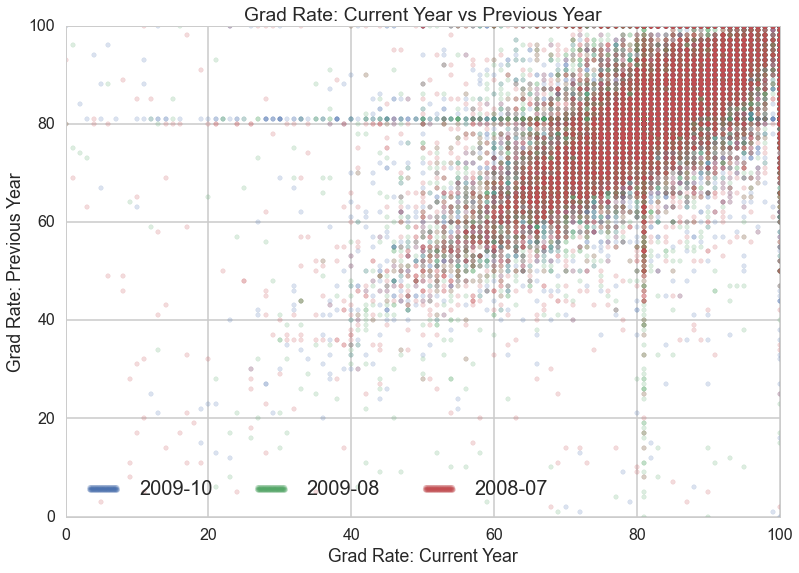

In [28]:
# Baseline Comparisons
from sklearn.metrics import mean_squared_error

y_0607 = df_yr['gradrate0607'].astype(int)
y_0708 = df_yr['gradrate0708'].astype(int)
y_0809 = df_yr['gradrate0809'].astype(int)
y_0910 = df_yr['afgr'].astype(int)

print "Mean Squared Error : "
rscore =  mean_squared_error(y_0910, y_0809)
print "Prediction for 2009-10 using 2009-09 : ", rscore

rscore =  mean_squared_error(y_0809, y_0708)
print "Prediction for 2008-09 using 2007-08 : ", rscore

rscore =  mean_squared_error(y_0708, y_0607)
print "Prediction for 2007-08 using 2006-07 : ", rscore

colors=sns.color_palette()
p1 = plt.scatter(y_0910, y_0809, alpha=0.2, color=colors[0])
p2 = plt.scatter(y_0809, y_0708, alpha=0.2, color=colors[1])
p3 = plt.scatter(y_0708, y_0607, alpha=0.2, color=colors[2])
    
plt.xlabel("Grad Rate: Current Year")
plt.ylabel("Grad Rate: Previous Year")
plt.title("Grad Rate: Current Year vs Previous Year")
plt.xlim(0,100)
plt.ylim(0,100)
plt.legend((p1, p2, p3),('2009-10', '2009-08', '2008-07'),
           scatterpoints=100,
           loc='lower left',
           ncol=3,
           fontsize=20)
plt.show()    

## Predictive Modelling using the current school districts datasets.

Here we try to build a model using only the school districts. The goal is that this model can help school asses what they could do to improve their perfomance. So focus is only on the indiciators over which schools like some control. 

In [205]:
fullprevyears = pd.read_csv("data/finaldata/dftouse_withprevyears.csv")

In [206]:
dftouse = fullprevyears.copy(deep=True)

In [207]:
dftouse.shape

(10785, 160)

In [208]:
dftouse.head()

,num_schools,num_charter_schools,num_pub_schools,num_students,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,afgr,i_agency_type_local_school_district,i_agency_type_local_school_district_sup_union,i_agency_type_regional_education_services,i_agency_type_charter_school_agency,i_fin_sdlc_sec,i_fin_sdlc_elem_sec,i_fin_sdlc_voc,i_ucl_city_large,i_ucl_city_mid,i_ucl_city_small,i_ucl_suburb_large,i_ucl_suburb_mid,i_ucl_suburb_small,i_ucl_town_fringe,i_ucl_town_distant,i_ucl_town_remote,i_ucl_rural_fringe,i_ucl_rural_distant,i_ucl_rural_remote,i_cs_all_charter,i_cs_charter_noncharter,...,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,gradrate0607,gradrate0708,gradrate0809
0,1,1,1,360,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,30.2,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0.000000,0.000000,0.000000,0.000000,0,1,80.772552,81.268948,81.805709
1,1,1,1,594,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,100.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.208316,0.166727,0.177190,0.024388,0.003395,0.005148,0.309150,0.048223,0.015101,0.003794,0.002556,0.036014,1,0,100.000000,100.000000,100.000000
2,1,1,1,1033,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,55.7,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0.011257,0.004972,0.769211,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,75.600000,41.400000,81.805709
3,3,0,3,432,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,70.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.769211,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,97.100000,81.600000,83.300000
4,2,0,2,595,15.64,13.37,10718,5634,4020,1065,4944,2103,336,4703,1438,11586,2769,0,7384,4944,19.5,67.0,4.6,63.7,28.5,9.9,52.6,37.5,95.7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0.061464,0.000000,0.769211,0.000000,0.043101,0.000000,0,0

In [209]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_HNPI','r_stud_re_Two','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_OGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_HNPI', 'r_stud_re_Two', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_r

In [210]:
INDICATORS = []
for v in dftouse.columns:
    l=np.unique(dftouse[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_regional_education_services', 'i_agency_type_charter_school_agency', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_K', 'i_lgo_PK']


In [211]:
#CITATION: From HW3
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [212]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [213]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 82.5862895748
% Graduation in Testing: 82.9390605686


In [214]:
#CITATION: From HW3
mask.shape, mask.sum()

((10785,), 7549)

In [215]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse[col].values[mask]
    valstest=dftouse[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse[col]=out

In [216]:
#CITATION: From HW3
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')
lcols.remove('gradrate0607')
lcols.remove('gradrate0708')
lcols.remove('gradrate0809')
###Check for Index Column if exixts in data and remove.
indexcol='Unnamed: 0'
if indexcol in list(dftouse.columns): lcols.remove(indexcol)
print len(lcols)

154


In [217]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

127 27


['num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'num_students',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurelsc_percent',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcuresal_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_HNPI',
 'r_stud_re_Two',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 

In [218]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [219]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

With so many features, we expect the performance of linear regression to be terrible.  We include this to justify why we need to use more sophisticated techniques such as lasso and elastic net to select the key features.

In [220]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [221]:
print lm.intercept_

163836.034619


<b>Top Factors - Positive</b>

In [222]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
128,r_srev_gfa,6.846079e+10
138,r_srev_aor,4.107836e+10
139,r_srev_splea,2.919768e+10
129,r_srev_sep,2.685793e+10
131,r_srev_sip,1.867126e+10
134,r_srev_codsp,1.629000e+10
141,r_srev_ns,1.311669e+10
130,r_srev_trans,1.234336e+10
132,r_srev_cbsp,8.097579e+09
133,r_srev_vep,3.646229e+09


<b>Top Factors - Negative</b>

In [223]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
148,r_frev_ao,-2.851683e+08
143,r_frev_dis,-2.145319e+08
142,r_frev_title1,-1.651628e+08
149,r_frev_ns,-1.566859e+08
144,r_frev_cna,-1.112821e+08
153,r_frev_aofed,-1.086761e+08
150,r_frev_ia,-9.347220e+07
145,r_frev_ems,-3.841922e+07
151,r_frev_be,-3.007251e+07
147,r_frev_voc,-2.416929e+07


In [224]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.36469313,  0.35761986,  0.38660675])

Linear Regression : Mean Squared Error :  2.11897145556e+19


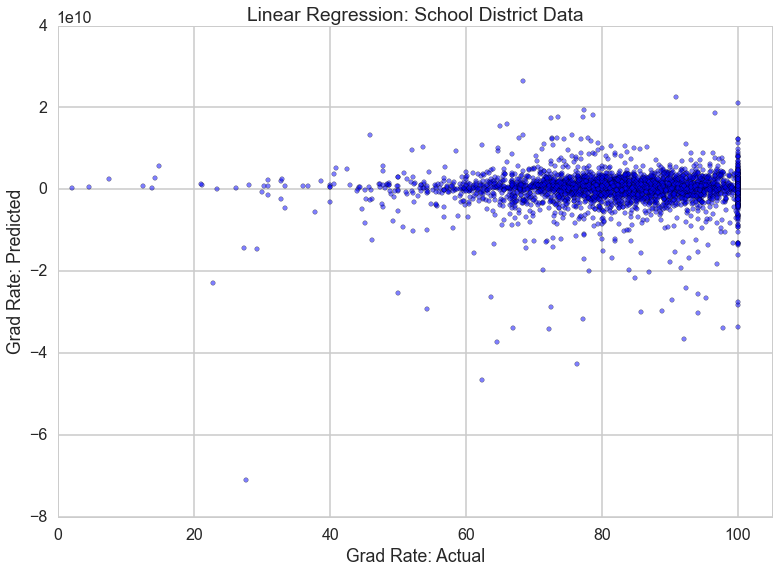

In [225]:
from sklearn.metrics import mean_squared_error

ypredict = lm.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Linear Regression : Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: School District Data")
plt.xlim(0,105)
#plt.ylim(0,105)
plt.show()    


##### Lasso Regression

Here we have a huge dataset, and lasso goes after the signficant fields so that we don't self select.


In [226]:
lasso = linear_model.Lasso()

In [227]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [228]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.541761
80,r_stud_reg_12_W_M,1.165075
26,tlocrev_percent,0.467191
0,num_schools,-0.000000
107,r_lrev_gst,-0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000


In [229]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-3.312818
67,r_stud_re_B,-1.548774
8,tsrev_pp,-0.561664
25,tfedrev_percent,-0.414278
9,tfedrev_pp,-0.068704
100,r_st_LEA,-0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000


r2

In [230]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.31777824,  0.30340675,  0.28960471])

Lasso Regression : Mean Squared Error :  128.682382592


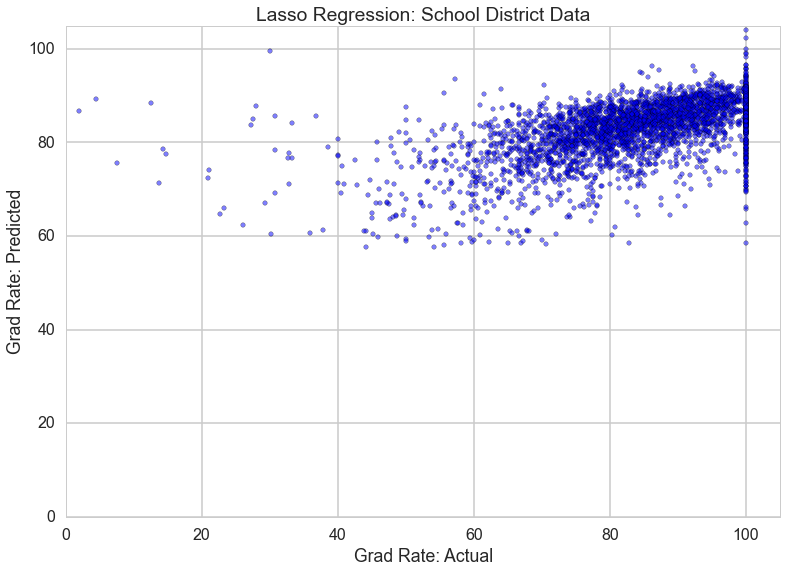

In [231]:
ypredict = lasso.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Lasso Regression : Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso Regression: School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

We hit a wall at actual graduation rate of 100%, with some of our predictions varying from 70% to 100%.

##### Elastic Net Regression

In [232]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [233]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,1.239553
80,r_stud_reg_12_W_M,1.098755
68,r_stud_re_W,0.795457
26,tlocrev_percent,0.693129
77,r_stud_reg_12_H_F,0.351569
23,tcuresal_percent,0.262755
75,r_stud_reg_12_AAP_F,0.227409
74,r_stud_reg_12_AAP_M,0.158365
63,r_stud_re_F,0.113068
59,r_stud_PKK,0.105005


In [234]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
57,r_lunch_free,-1.950453
67,r_stud_re_B,-1.240224
25,tfedrev_percent,-0.800888
8,tsrev_pp,-0.500096
60,r_stud_18,-0.444123
9,tfedrev_pp,-0.343794
142,r_frev_title1,-0.343191
90,r_st_UT,-0.334007
107,r_lrev_gst,-0.321746
24,tcurssvc_percent,-0.263275


In [235]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.32812438,  0.3043909 ,  0.31874612])

Elastic Net : Mean Squared Error :  125.889829557


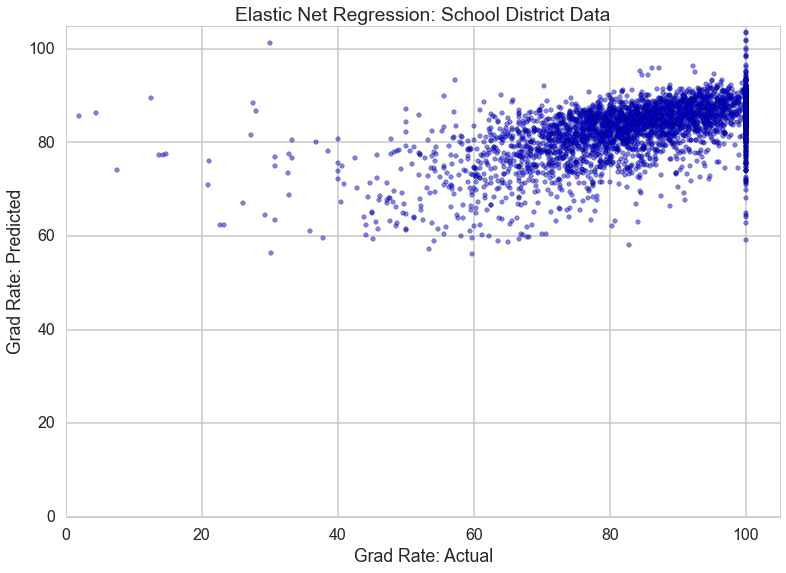

In [236]:
ypredict = elasticnet.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Elastic Net : Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

We hit a wall at actual graduation rate of 100% again, with predictions between 70% and 100%.  Of our three models of school district data only, elastic net provides the best results.

#### Decision Tree & Random Forests

In [368]:
dfdr=pd.read_csv("data/finaldata/dftouse.csv")
print dfdr.shape

# Create test/train mask
itrain_dr1, itest_dr1 = train_test_split(xrange(dfdr.shape[0]), train_size=0.7)
mask_dr1=np.ones(dfdr.shape[0], dtype='int')
mask_dr1[itrain_dr1]=1
mask_dr1[itest_dr1]=0
mask_dr1 = (mask_dr1==1)

# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dfdr['afgr'][mask_dr1])
print "% Graduation in Testing:", np.mean(dfdr['afgr'][~mask_dr1])

# Indicators used : Funding/Expenditure/Location/School Types (no Race)
Xnames2 = [
            'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP',
            'r_lunch_free',
            'r_lunch_reduced'
]

# Target :
# Adding Target column :
dfdr['target'] = dfdr['afgr'].astype(int)
target2 = 'target'


(10785, 157)
% Graduation in Training: 82.5769770831
% Graduation in Testing: 82.9607849197


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 13, 'min_samples_leaf': 20} -0.222224145502 [mean: -0.31357, std: 0.08894, params: {'max_depth': 10, 'min_samples_leaf': 10}, mean: -0.31278, std: 0.04026, params: {'max_depth': 10, 'min_samples_leaf': 11}, mean: -0.29852, std: 0.05052, params: {'max_depth': 10, 'min_samples_leaf': 12}, mean: -0.29272, std: 0.05331, params: {'max_depth': 10, 'min_samples_leaf': 13}, mean: -0.30353, std: 0.06196, params: {'max_depth': 10, 'min_samples_leaf': 14}, mean: -0.29367, std: 0.06694, params: {'max_depth': 10, 'min_samples_leaf': 15}, mean: -0.28253, std: 0.03369, params: {'max_depth': 10, 'min_samples_leaf': 16}, mean: -0.29391, std: 0.02013, params: {'max_depth': 10, 'min_samples_leaf': 17}, mean: -0.33733, std: 0.06939, params: {'max_depth': 10, 'min_samples_leaf': 18}, mean: -0.29145, std: 0.03723, params: {'max_depth': 10, 'min_samples_leaf': 19}, mean: -0.29651, std: 0.03978, params: {'max_depth': 10, 'min_samples_leaf': 20}, mean: -0.29572, std: 0.05237, params: {'max_d

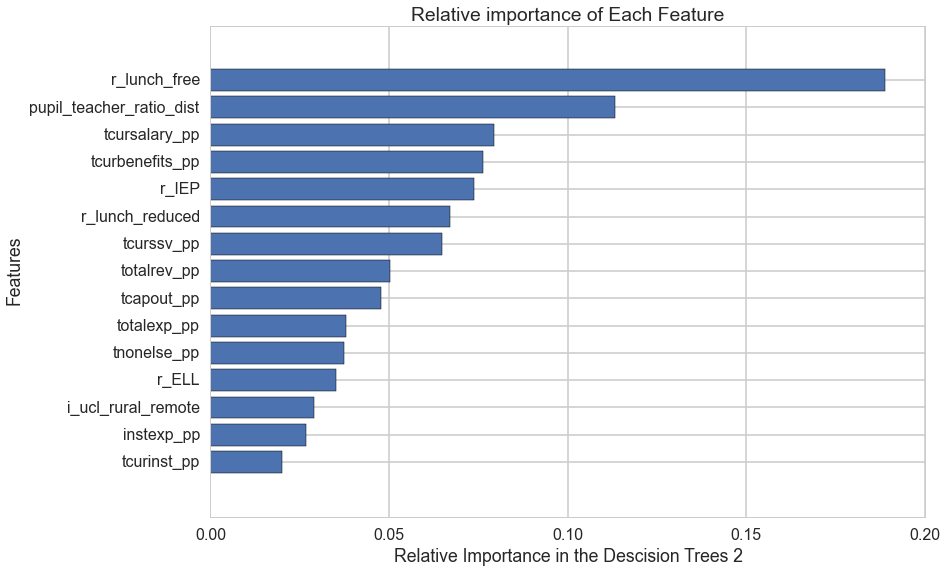

In [370]:
# Decision Trees
from sklearn import tree
clfTree2 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [10, 11, 12, 13, 14, 15], 'min_samples_leaf': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
clfTree2, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree2, parameters, dfdr, 
                                                     Xnames2, target2, 1, 
                                                     mask=mask_dr1, n_jobs = 4, score_func = 'r2')

importance_list = clfTree2.feature_importances_
name_list = dfdr[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Descision Trees 2')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


Mean Squared Error :  218.606613103


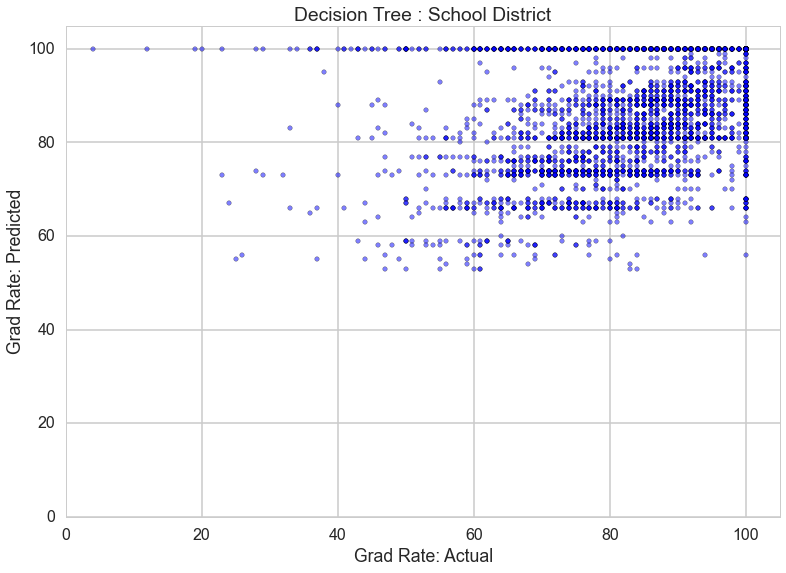

In [371]:
ypredict = clfTree2.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Decision Tree : School District")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 18} -0.310739515573 [mean: -0.53765, std: 0.15353, params: {'n_estimators': 1}, mean: -0.64786, std: 0.29067, params: {'n_estimators': 2}, mean: -0.91929, std: 0.22069, params: {'n_estimators': 3}, mean: -1.00916, std: 0.27087, params: {'n_estimators': 4}, mean: -1.08944, std: 0.29275, params: {'n_estimators': 5}, mean: -1.13645, std: 0.24979, params: {'n_estimators': 6}, mean: -0.96025, std: 0.22346, params: {'n_estimators': 7}, mean: -0.95468, std: 0.25764, params: {'n_estimators': 8}, mean: -0.76561, std: 0.17615, params: {'n_estimators': 9}, mean: -0.63919, std: 0.12012, params: {'n_estimators': 10}, mean: -0.58850, std: 0.11964, params: {'n_estimators': 11}, mean: -0.46967, std: 0.11754, params: {'n_estimators': 12}, mean: -0.42887, std: 0.08869, params: {'n_estimators': 13}, mean: -0.40435, std: 0.06041, params: {'n_estimators': 14}, mean: -0.37523, std: 0.07093, params: {'n_estimators': 15}, mean: -0.38568, std: 0.09091, params: {'n_estimators': 16}, mean: 

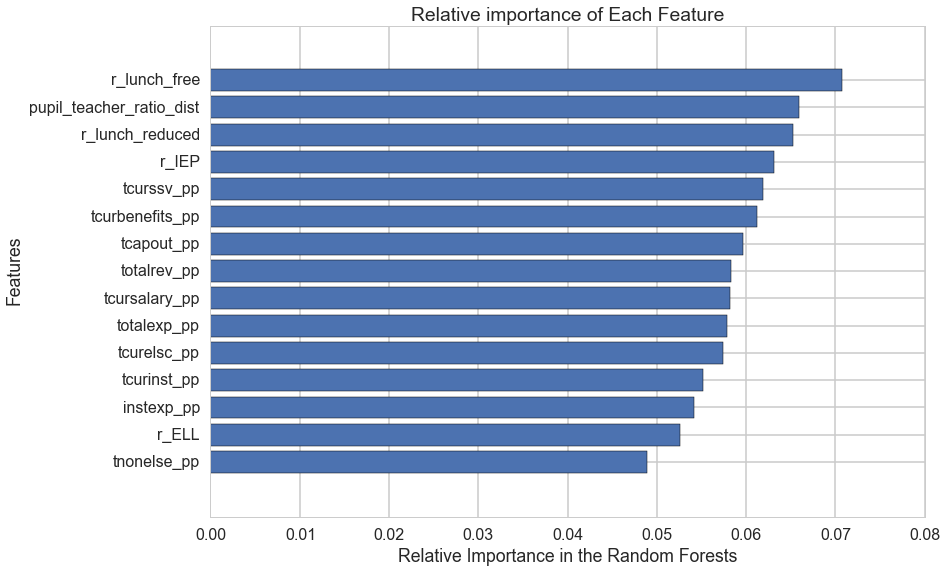

In [372]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier
clfForest2 = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest2, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest2, parameters, 
                                                       dfdr, Xnames2, target2, 1, mask=mask_dr1, 
                                                       n_jobs = 4, score_func='r2')

importance_list = clfForest2.feature_importances_
name_list = dfdr[Xnames2].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

Mean Squared Error :  241.701792336


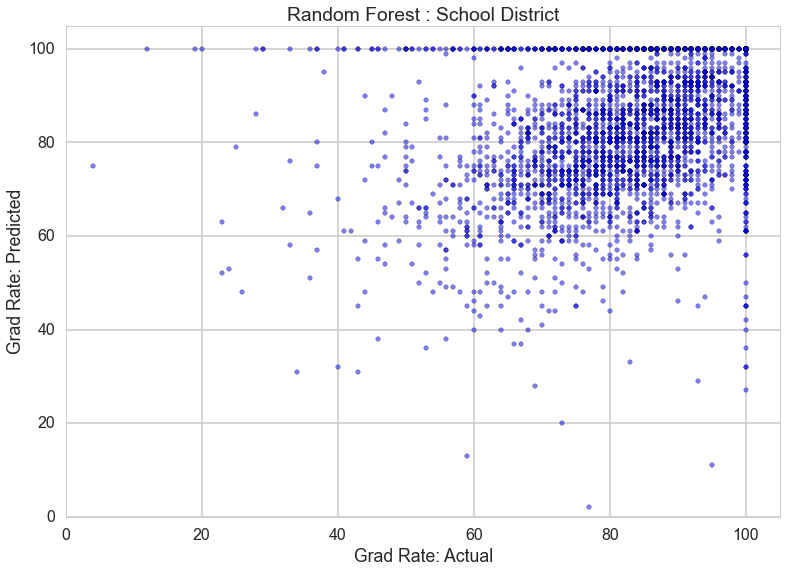

In [373]:
ypredict = clfForest2.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Random Forest : School District ")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

## Predicting graduation based on previous year graduation

We now add previous years of graduation data into our models to see if they outperform the model of school district data alone.  We expect that adding in previous years of graduation data will outperform the models of school district data alone.

In [238]:
dftouse.fillna(value=0,inplace=True)

As we add in previous years of data, some of those previous years do not have data for some of the school districts.  Therefore, the row counts will drop.

In [239]:
dftouse = dftouse[dftouse['gradrate0607']>0]
print 'Has 0607 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0708']>0]
print 'Has 0708 Grad Data: ' + str(len(dftouse))
dftouse = dftouse[dftouse['gradrate0809']>0]
print 'Has 0809 Grad Data: ' + str(len(dftouse))

Has 0607 Grad Data: 10785
Has 0708 Grad Data: 10784
Has 0809 Grad Data: 10783


In [240]:
dftouse.shape

(10783, 160)

In [241]:
gradpred = dftouse.copy(deep=True)

In [242]:
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [243]:
#CITATION: From HW3
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [244]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse['afgr'][~mask])

% Graduation in Training: 82.6549947006
% Graduation in Testing: 82.7872642968


In [245]:
Xmatrix=dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [246]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression - 0607, 0708, and 0809

You have multiple previous years of school district graduation data available to you, and you want to add all of them into the model to predict graduation outcome.  This would be like saying, I want to predict school year 2014-2015 graduation rates, and I have 2013-2014, 2012-2013, and 2011-2012 school years of graduation rates available.  This is not a realistic scenario for the general public - the latest school year of graduation rate data publically available is 2009-2010.  That means there is a 5 year lapse in data availability, which would not make this regression possible to the general public if it we were the year 2009-2010.

In [247]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [248]:
pd.DataFrame(zip(dftouse[['gradrate0607', 'gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.188040
1,gradrate0708,0.254905
2,gradrate0809,0.354630


In [249]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.45364231,  0.4480428 ,  0.48609109])

In [250]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

96.259827122680122

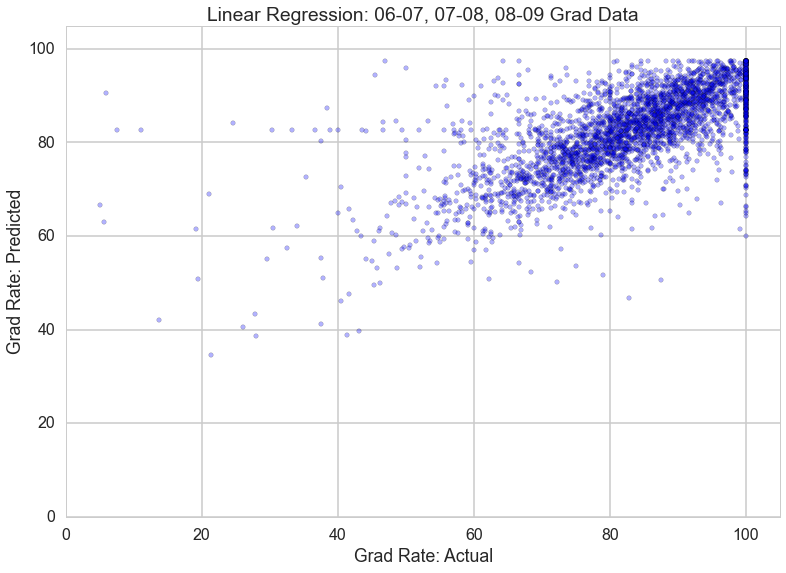

In [251]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 06-07, 07-08, 08-09 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model outperforms all other models created thus far.  It hits the same wall at 100% graduation as the other models.  As noted earlier, this is not a realistic scenario because the most recent data that would have been available during school year 2009-2010 would have been 2004-2005.

##### Linear Regression - 0708 and 0809

This model assumes you have the two most current previous years of data available to you.

In [252]:
Xmatrix=dftouse[['gradrate0708', 'gradrate0809']].values
Yresp=dftouse['afgr'].values

In [253]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [254]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [255]:
print lm.intercept_
print lm.coef_

20.444005339
[ 0.34651434  0.41593984]


In [256]:
pd.DataFrame(zip(dftouse[['gradrate0708', 'gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.346514
1,gradrate0809,0.415940


In [257]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.42819447,  0.43726416,  0.4676011 ])

In [258]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

99.637853083123559

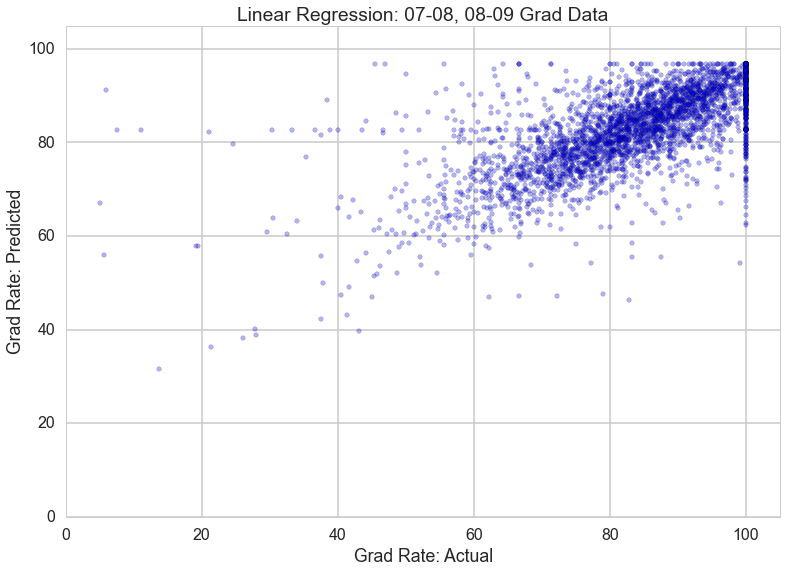

In [259]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 07-08, 08-09 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model is less accurate than having 3 years of graduation data available, yet still more accurate than all of our previous models.

##### Linear Regression - 0809 Only

This model assumes you have the most recent previous year available.

In [260]:
Xmatrix=dftouse[['gradrate0809']].values
Yresp=dftouse['afgr'].values

In [261]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [262]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [263]:
print lm.intercept_
print lm.coef_

29.687441265
[ 0.64703357]


In [264]:
pd.DataFrame(zip(dftouse[['gradrate0809']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0809,0.647034


In [265]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.36060434,  0.36953741,  0.37925459])

In [266]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

114.70927641743916

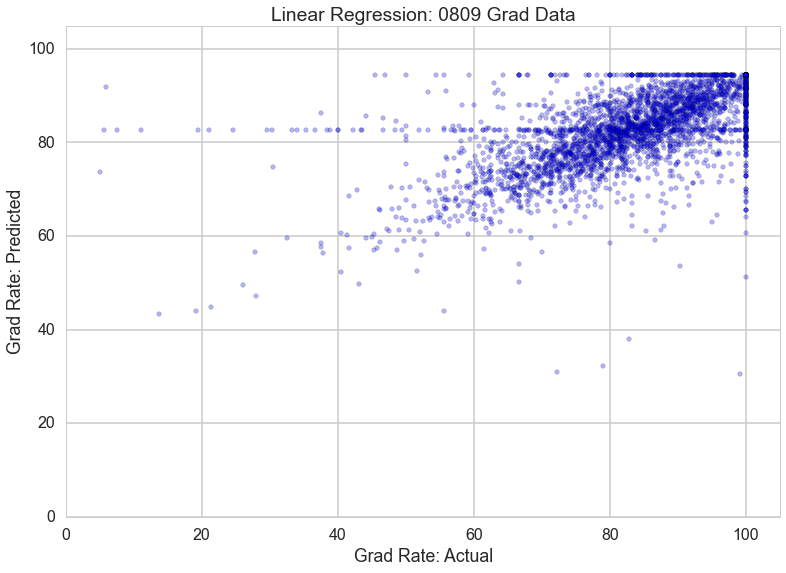

In [267]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0809 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

This model performs worse than the two previous.  It hits a wall at both actual grad rate and predicted grad rate.

##### Linear Regression - 0708 Only

This model assumes two years prior data available only.

In [268]:
Xmatrix=dftouse[['gradrate0708']].values
Yresp=dftouse['afgr'].values

In [269]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [270]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [271]:
print lm.intercept_
print lm.coef_

34.7738087429
[ 0.58916098]


In [272]:
pd.DataFrame(zip(dftouse[['gradrate0708']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0708,0.589161


In [273]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.32280937,  0.34751562,  0.38107179])

In [274]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

115.27305941837383

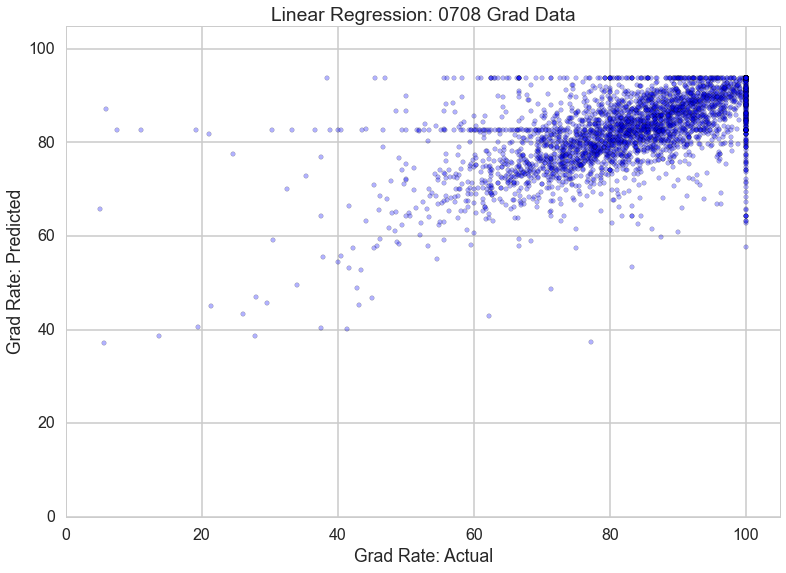

In [275]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0708 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Linear Regression - 0607 Only

This model assumes three years prior data available only.

In [276]:
Xmatrix=dftouse[['gradrate0607']].values
Yresp=dftouse['afgr'].values

In [277]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [278]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [279]:
print lm.intercept_
print lm.coef_

38.0255534965
[ 0.55324569]


In [280]:
pd.DataFrame(zip(dftouse[['gradrate0607']].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,gradrate0607,0.553246


In [281]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.34062551,  0.29943651,  0.31813816])

In [282]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

124.37565458009647

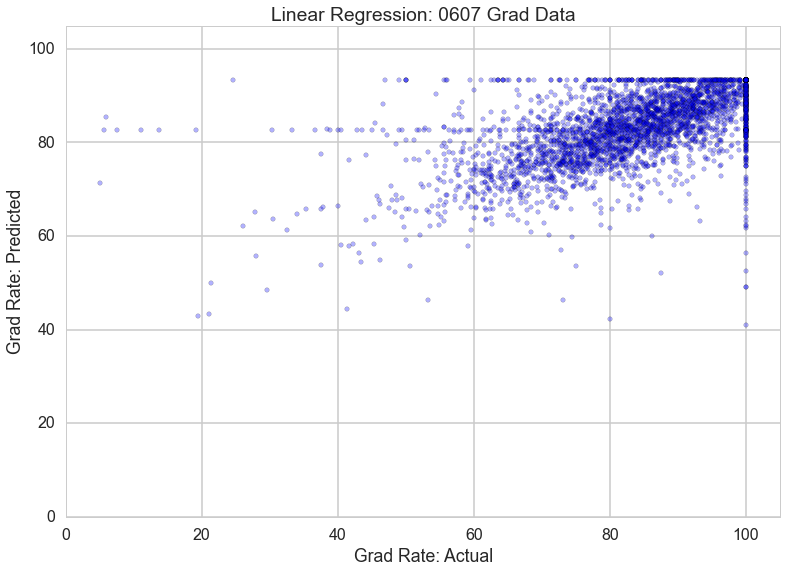

In [283]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 0607 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

If you only have graduation data available for 3 years prior, the performance is the worst.  Again, walls at actual and predicted 100% graduation rate.  This model overpredicts, telling a school district that it is doing better than it is, which is not a good scenario.

## Predicting graduation based on previous year graduation and all other factors

If we married the previous years of graduation data and the school district data, could we create the best model?  Is it better than just graduation rate alone?

In [284]:
lcols=list(dftouse.columns)
lcols.remove('RESP_High_Graduation')
lcols.remove('RESP_Low_Graduation')
lcols.remove('afgr')

In [285]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [286]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

In [287]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [288]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
34,i_fin_sdlc_voc,10.833789
18,tcurelsc_pp,9.617015
33,i_fin_sdlc_elem_sec,9.372606
54,i_lgo_PK,7.170665
53,i_lgo_K,6.893866
0,num_schools,6.641498
101,r_st_LEASS,5.879462
148,r_frev_ao,5.565641
32,i_fin_sdlc_sec,5.094310
128,r_srev_gfa,4.702548


In [289]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
26,tlocrev_percent,-38.035606
27,tsrev_percent,-34.018567
25,tfedrev_percent,-14.698286
91,r_st_TS,-10.003194
68,r_stud_re_W,-9.298882
21,tcurinst_percent,-7.825261
2,num_pub_schools,-7.714817
24,tcurssvc_percent,-7.695972
30,i_agency_type_regional_education_services,-7.089685
67,r_stud_re_B,-6.779637


In [290]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.48996459,  0.43592357,  0.51999977])

In [291]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

89.679583680189253

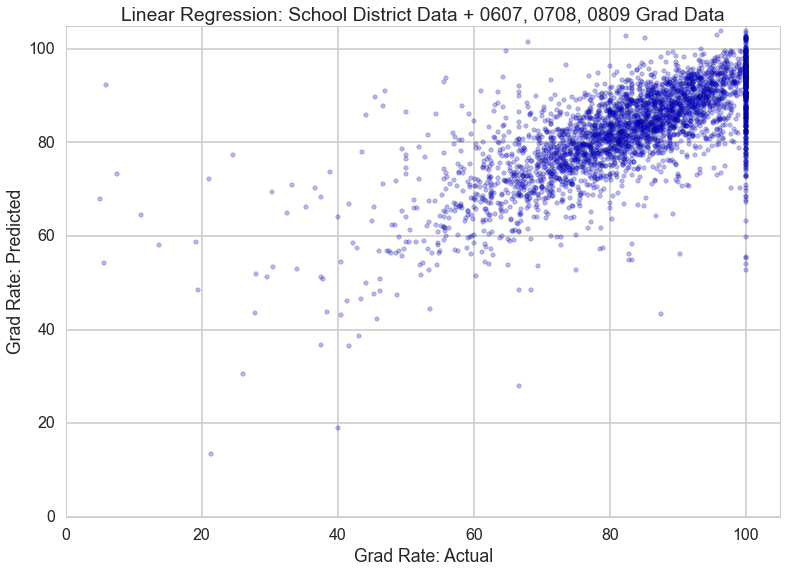

In [292]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: School District Data + 0607, 0708, 0809 Grad Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Lasso Regression

In [293]:
lasso = linear_model.Lasso()

In [294]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [295]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.880563
156,gradrate0809,0.336472
155,gradrate0708,0.240823
154,gradrate0607,0.171633
108,r_lrev_put,0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000


In [296]:
pd.DataFrame(zip(dftouse[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.185954
100,r_st_LEA,-0.000000
101,r_st_LEASS,-0.000000
102,r_st_SA,-0.000000
103,r_st_SASS,-0.000000
104,r_st_SSSS,-0.000000
105,r_st_OSSS,0.000000
106,r_lrev_pt,0.000000
107,r_lrev_gst,-0.000000
108,r_lrev_put,0.000000


In [297]:
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.46741886,  0.46351771,  0.4990405 ])

In [298]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

93.677188958100984

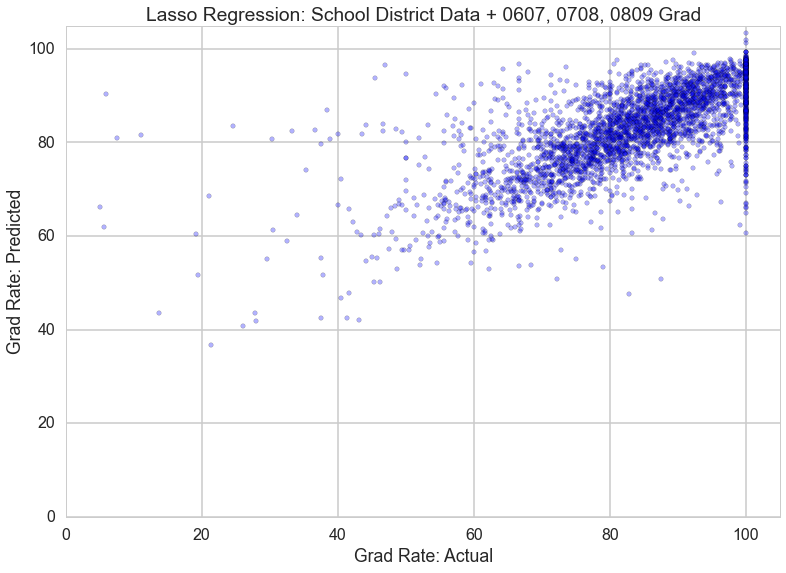

In [299]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso Regression: School District Data + 0607, 0708, 0809 Grad")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Elastic Net Regression

In [300]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [301]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
81,r_stud_reg_12_W_F,0.724249
80,r_stud_reg_12_W_M,0.390046
156,gradrate0809,0.321462
77,r_stud_reg_12_H_F,0.263953
155,gradrate0708,0.231649
23,tcuresal_percent,0.206815
154,gradrate0607,0.159676
26,tlocrev_percent,0.113949
74,r_stud_reg_12_AAP_M,0.079391
106,r_lrev_pt,0.008552


In [302]:
pd.DataFrame(zip(dftouse[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
57,r_lunch_free,-0.386189
67,r_stud_re_B,-0.253313
8,tsrev_pp,-0.224147
132,r_srev_cbsp,-0.136606
119,r_lrev_osalserv,-0.099034
9,tfedrev_pp,-0.080264
25,tfedrev_percent,-0.064001
60,r_stud_18,-0.056252
17,tnonelse_pp,-0.053719
122,r_lrev_molr,-0.009340


In [303]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.48120317,  0.47189244,  0.50903098])

In [304]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

91.59125369683909

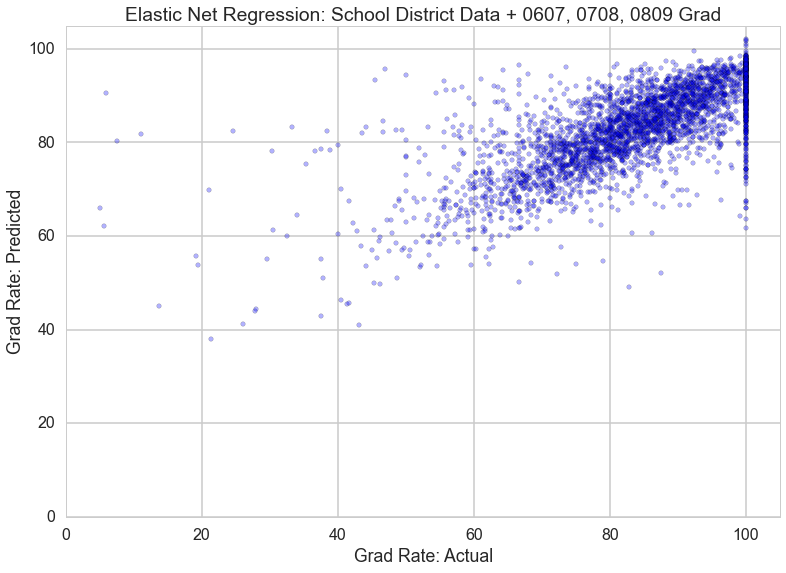

In [305]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: School District Data + 0607, 0708, 0809 Grad")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

### Decision Trees and Random Forests

In [306]:
# Create test/train mask
itrain_dr, itest_dr = train_test_split(xrange(df_yr.shape[0]), train_size=0.7)
mask_dr=np.ones(df_yr.shape[0], dtype='int')
mask_dr[itrain_dr]=1
mask_dr[itest_dr]=0
mask_dr = (mask_dr==1)

# Indicators used : Funding/Expenditure/Location/School Types and Race/Sex
Xnames1 = [
            'pupil_teacher_ratio_dist',
            'totalrev_pp',
            'tcurinst_pp',
            'tcurssv_pp',
            'tcursalary_pp',
            'tcurbenefits_pp',
            'totalexp_pp',
            'tcapout_pp',
            'tnonelse_pp',
            'tcurelsc_pp',
            'instexp_pp',
            'i_agency_type_local_school_district',
            'i_agency_type_local_school_district_sup_union',
            'i_agency_type_regional_education_services',
            'i_agency_type_charter_school_agency',
            'i_fin_sdlc_sec',
            'i_fin_sdlc_elem_sec',
            'i_fin_sdlc_voc',
            'i_ucl_city_large',
            'i_ucl_city_mid',
            'i_ucl_city_small',
            'i_ucl_suburb_large',
            'i_ucl_suburb_mid',
            'i_ucl_suburb_small',
            'i_ucl_town_fringe',
            'i_ucl_town_distant',
            'i_ucl_town_remote',
            'i_ucl_rural_fringe',
            'i_ucl_rural_distant',
            'i_ucl_rural_remote',
            'i_cs_all_charter',
            'i_cs_charter_noncharter',
            'i_cs_all_noncharter',
            'i_ma_ne_nr',
            'i_ma_metropolitan',
            'i_ma_micropolitan',            
            'r_ELL',
            'r_IEP',
            'r_stud_re_M',
            'r_stud_re_F',
            'r_stud_re_AIAN',
            'r_stud_re_AAP',
            'r_stud_re_H',
            'r_stud_re_B',
            'r_stud_re_W',
            'r_stud_re_HNPI',
            'r_stud_re_Two',
            'gradrate0607',
            'gradrate0708',
            'gradrate0809',
            'r_lunch_free',
            'r_lunch_reduced'

]
# Adding Target column :
df_yr['target'] = df_yr['afgr'].astype(int)
target1 = 'target'


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 10, 'min_samples_leaf': 13} 0.201065709555 [mean: -0.00919, std: 0.08034, params: {'max_depth': 5, 'min_samples_leaf': 5}, mean: -0.01106, std: 0.07881, params: {'max_depth': 5, 'min_samples_leaf': 6}, mean: -0.01130, std: 0.07901, params: {'max_depth': 5, 'min_samples_leaf': 7}, mean: -0.01072, std: 0.07880, params: {'max_depth': 5, 'min_samples_leaf': 8}, mean: -0.01072, std: 0.07880, params: {'max_depth': 5, 'min_samples_leaf': 9}, mean: -0.01006, std: 0.07990, params: {'max_depth': 5, 'min_samples_leaf': 10}, mean: -0.00869, std: 0.07787, params: {'max_depth': 5, 'min_samples_leaf': 11}, mean: -0.00865, std: 0.07789, params: {'max_depth': 5, 'min_samples_leaf': 12}, mean: -0.00950, std: 0.07703, params: {'max_depth': 5, 'min_samples_leaf': 13}, mean: -0.00529, std: 0.07135, params: {'max_depth': 5, 'min_samples_leaf': 14}, mean: -0.00624, std: 0.07267, params: {'max_depth': 5, 'min_samples_leaf': 15}, mean: 0.05577, std: 0.13439, params: {'max_depth': 6, 'min_sam

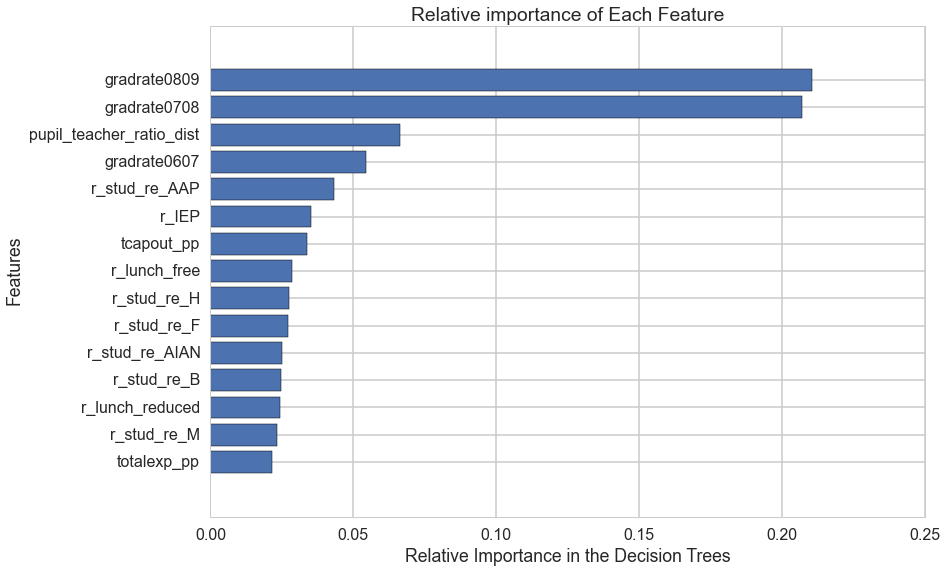

In [307]:
# Descision Trees
from sklearn import tree

clfTree1 = tree.DecisionTreeClassifier()

parameters = {"max_depth": [5, 6, 7, 9, 10, 11, 12], 'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
clfTree1, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree1, parameters, df_yr, 
                                                     Xnames1, target1, 1, 
                                                     mask=mask_dr, n_jobs = 4, score_func = 'r2')

importance_list = clfTree1.feature_importances_
name_list = df_yr[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Decision Trees')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


Mean Squared Error :  153.386279357


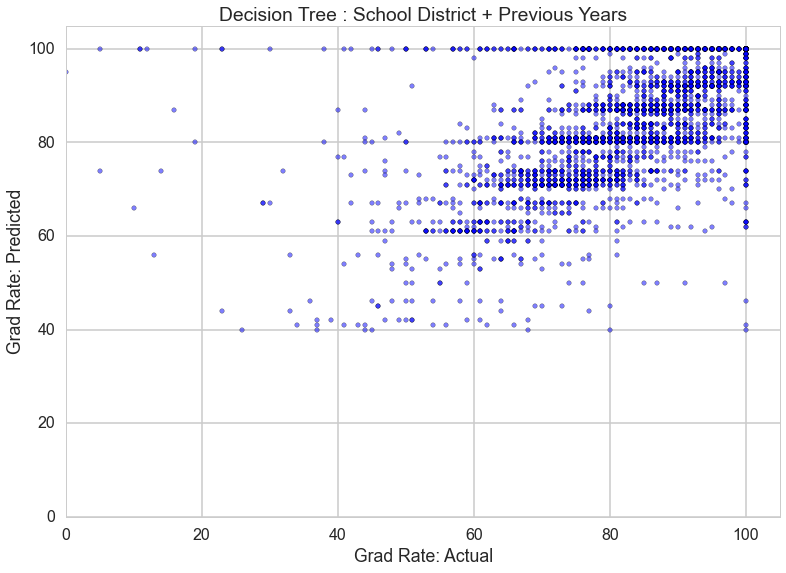

In [308]:
ypredict = clfTree1.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Decision Tree : School District + Previous Years")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 30} 0.136262380312 [mean: 0.11188, std: 0.02741, params: {'n_estimators': 25}, mean: 0.10349, std: 0.03705, params: {'n_estimators': 26}, mean: 0.08091, std: 0.03741, params: {'n_estimators': 27}, mean: 0.06603, std: 0.03665, params: {'n_estimators': 28}, mean: 0.07589, std: 0.01211, params: {'n_estimators': 29}, mean: 0.13626, std: 0.03215, params: {'n_estimators': 30}, mean: 0.07856, std: 0.02747, params: {'n_estimators': 31}, mean: 0.09177, std: 0.04194, params: {'n_estimators': 32}, mean: 0.06913, std: 0.02878, params: {'n_estimators': 33}, mean: 0.10540, std: 0.01953, params: {'n_estimators': 34}, mean: 0.08838, std: 0.02288, params: {'n_estimators': 35}, mean: 0.07140, std: 0.02246, params: {'n_estimators': 36}, mean: 0.08011, std: 0.02063, params: {'n_estimators': 37}, mean: 0.08605, std: 0.02341, params: {'n_estimators': 38}, mean: 0.09952, std: 0.03631, params: {'n_estimators': 39}]


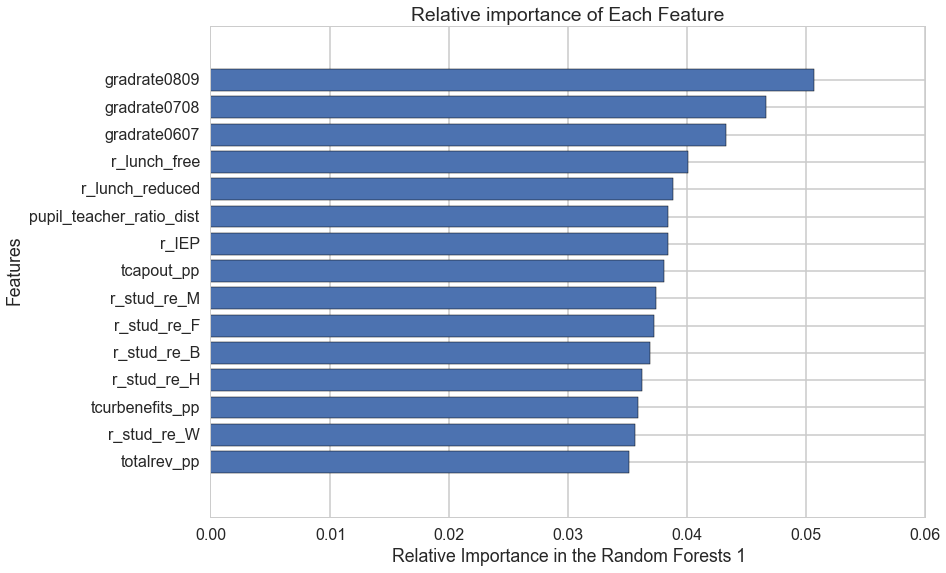

In [309]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

clfForest1 = RandomForestClassifier()

parameters = {"n_estimators": range(25, 40)}
clfForest1, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest1, parameters, 
                                                       df_yr, Xnames1, target1, 1, mask=mask_dr, 
                                                       n_jobs = 4, score_func='r2')

importance_list = clfForest1.feature_importances_
name_list = df_yr[Xnames1].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list))[-15:])
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forests 1')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

Mean Squared Error :  167.071075402


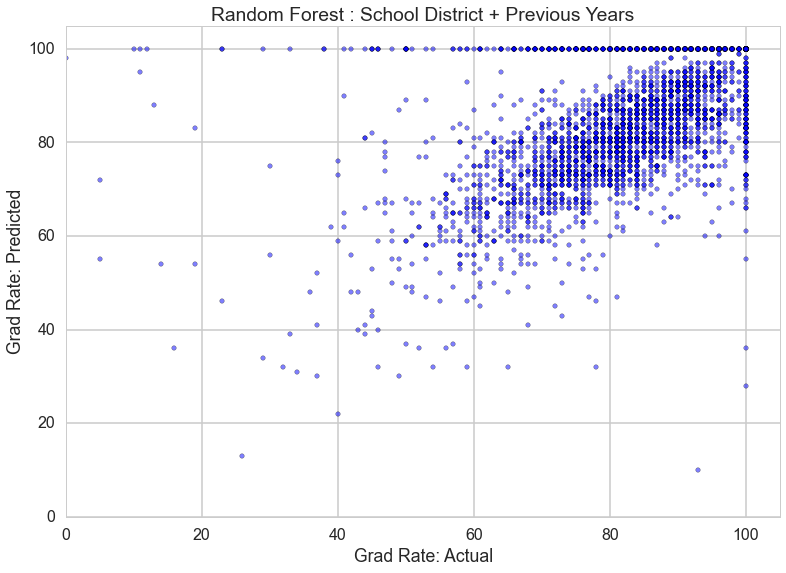

In [310]:
ypredict = clfForest1.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Random Forest : School District + Previous Years")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()    

### Creating a best model

We use the columns selected by our best model (elastic net) to inform what features we should select for a linear regression and see if we can beat any of the models with graduation rate in them.

In [311]:
lcols=['r_stud_reg_12_W_F', 'r_stud_reg_12_W_M', 'tlocrev_percent', 'r_stud_re_W', 'r_lrev_pt', 'r_lunch_free', 'r_stud_re_B', 'tfedrev_percent', 'r_stud_18', 'tsrev_pp', 'tcuresal_percent', 'r_frev_title1', 'tcurinst_percent', 'r_lrev_molr']

In [312]:
Xmatrix=dftouse[lcols].values
Yresp=dftouse['afgr'].values

In [313]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [314]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [315]:
pd.DataFrame(zip(dftouse[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_reg_12_W_F,1.944409
1,r_stud_reg_12_W_M,1.214658
2,tlocrev_percent,0.257012
3,r_stud_re_W,-0.173361
4,r_lrev_pt,0.146182
5,r_lunch_free,-2.896304
6,r_stud_re_B,-2.116497
7,tfedrev_percent,-1.158260
8,r_stud_18,-1.422072
9,tsrev_pp,-1.629074


In [316]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.3038443 ,  0.31224806,  0.35683494])

In [317]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

126.19517764740569

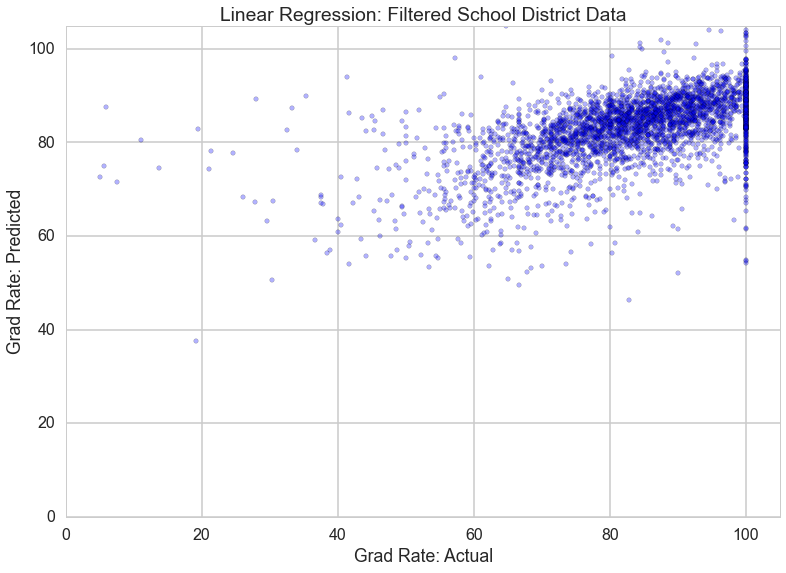

In [318]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: Filtered School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

The mean squared error for the 0607 graduation rate only model and the filtered school district model are nearly identical.  Therefore, if we only have school district information, its predictive ability is akin to having a graduation rate 3 years back.  We could posit that in the scenario of not receiving public graduation data until 5 years later, we could use school district characteristics to predict the graduation rates 3 years in advance until such time that better data is available.

### Findings

Linear Regression - 0607 Only and Best Model have very similar MSE.  The 0607 Only model overpredicts.  The Best Model underpredicts.  Underprediction is better than overprediction in this scenario - it is disadvantageous if the school district thinks it is performing better than it is.

This brings to mind an interesting scenario.  We started this project with 09-10 graduation data because it was the newest data available.  Given the similarity in the 0607 Only and Best model, if all we have is school district information, it may be worthwhile checking if we can predict with the same quality as the 0607 Only model.  If quality is similar, we might be able to predict 12-13 graduation rates several years before they are released to the public.

We go back to ELSI to download 0607 school district information to test this out.

## Trying 2009-2010 predictions using 2006-2007 data

In [319]:
dftouse0607 = pd.read_csv("data/finaldata/dftouse_0607_with0910grad.csv")

In [320]:
dftouse0607.shape

(9582, 417)

In [321]:
STANDARDIZABLE = ['num_students', 'num_schools','num_charter_schools','num_pub_schools','tcuresal_percent','pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp','tlocrev_pp','tsrev_pp','tfedrev_pp','tcurinst_pp','tcurssv_pp','tcuroth_pp','tcursalary_pp','tcurbenefits_pp','totalexp_pp','tcapout_pp','tnonelse_pp','tcurelsc_pp','instexp_pp','tcurinst_percent','tcuroth_percent','tcurelsc_percent','tcurssvc_percent','tfedrev_percent','tlocrev_percent','tsrev_percent','r_ELL','r_IEP','r_lunch_free','r_lunch_reduced','r_stud_PKK','r_stud_18','r_stud_912','r_stud_re_M','r_stud_re_F','r_stud_re_AIAN','r_stud_re_AAP','r_stud_re_H','r_stud_re_B','r_stud_re_W','r_stud_re_Total','r_stud_reg_12_AIAN_M','r_stud_reg_12_AIAN_F','r_stud_reg_12_AAP_M','r_stud_reg_12_AAP_F','r_stud_reg_12_H_M','r_stud_reg_12_H_F','r_stud_reg_12_B_M','r_stud_reg_12_B_F','r_stud_reg_12_W_M','r_stud_reg_12_W_F','r_stud_reg_12_HNPI_M','r_stud_reg_12_HNPI_F','r_stud_reg_12_Two_M','r_stud_reg_12_Two_F','r_st_PKT','r_st_KT','r_st_ET','r_st_ST','r_st_UT','r_st_TS','r_st_IA','r_st_IC','r_st_EGC','r_st_SGC','r_st_TGC','r_st_LMS','r_st_LMSS','r_st_LEA','r_st_LEASS','r_st_SA','r_st_SASS','r_st_SSSS','r_st_OSSS','r_lrev_pt','r_lrev_gst','r_lrev_put','r_lrev_it','r_lrev_aot','r_lrev_pgc','r_lrev_cc','r_lrev_oss','r_lrev_tui','r_lrev_trans','r_lrev_slr','r_lrev_ts','r_lrev_sar','r_lrev_osalserv','r_lrev_sfns','r_lrev_ie','r_lrev_molr','r_lrev_sp','r_lrev_rr','r_lrev_sale','r_lrev_ff','r_lrev_pc','r_srev_gfa','r_srev_sep','r_srev_trans','r_srev_sip','r_srev_cbsp','r_srev_vep','r_srev_codsp','r_srev_bep','r_srev_gt','r_srev_slp','r_srev_aor','r_srev_splea','r_srev_osp','r_srev_ns','r_frev_title1','r_frev_dis','r_frev_cna','r_frev_ems','r_frev_dfs','r_frev_voc','r_frev_ao','r_frev_ns','r_frev_ia','r_frev_be','r_frev_na','r_frev_aofed']
print STANDARDIZABLE

['num_students', 'num_schools', 'num_charter_schools', 'num_pub_schools', 'tcuresal_percent', 'pupil_teacher_ratio_dist', 'pupil_teacher_ratio_ps', 'totalrev_pp', 'tlocrev_pp', 'tsrev_pp', 'tfedrev_pp', 'tcurinst_pp', 'tcurssv_pp', 'tcuroth_pp', 'tcursalary_pp', 'tcurbenefits_pp', 'totalexp_pp', 'tcapout_pp', 'tnonelse_pp', 'tcurelsc_pp', 'instexp_pp', 'tcurinst_percent', 'tcuroth_percent', 'tcurelsc_percent', 'tcurssvc_percent', 'tfedrev_percent', 'tlocrev_percent', 'tsrev_percent', 'r_ELL', 'r_IEP', 'r_lunch_free', 'r_lunch_reduced', 'r_stud_PKK', 'r_stud_18', 'r_stud_912', 'r_stud_re_M', 'r_stud_re_F', 'r_stud_re_AIAN', 'r_stud_re_AAP', 'r_stud_re_H', 'r_stud_re_B', 'r_stud_re_W', 'r_stud_re_Total', 'r_stud_reg_12_AIAN_M', 'r_stud_reg_12_AIAN_F', 'r_stud_reg_12_AAP_M', 'r_stud_reg_12_AAP_F', 'r_stud_reg_12_H_M', 'r_stud_reg_12_H_F', 'r_stud_reg_12_B_M', 'r_stud_reg_12_B_F', 'r_stud_reg_12_W_M', 'r_stud_reg_12_W_F', 'r_stud_reg_12_HNPI_M', 'r_stud_reg_12_HNPI_F', 'r_stud_reg_12_Two_M

In [322]:
INDICATORS = []
for v in dftouse0607.columns:
    l=np.unique(dftouse0607[v])
    if len(l) <= 10:
        INDICATORS.append(v)
        
INDICATORS.remove('RESP_High_Graduation')        
INDICATORS.remove('RESP_Low_Graduation')  
INDICATORS.remove('Metro Status Code [District] 2009-10')
INDICATORS.remove('Gender Unknown Students [Public School] 2009-10')
print INDICATORS

['i_agency_type_local_school_district', 'i_agency_type_local_school_district_sup_union', 'i_agency_type_sup_union_admin', 'i_agency_type_regional_education_services', 'i_agency_type_state_operated_institution', 'i_agency_type_charter_school_agency', 'i_agency_type_other_education_agency', 'i_fin_sdlc_elem', 'i_fin_sdlc_sec', 'i_fin_sdlc_elem_sec', 'i_fin_sdlc_voc', 'i_fin_sdlc_nonop', 'i_fin_sdlc_ed_serv', 'i_ucl_city_large', 'i_ucl_city_mid', 'i_ucl_city_small', 'i_ucl_suburb_large', 'i_ucl_suburb_mid', 'i_ucl_suburb_small', 'i_ucl_town_fringe', 'i_ucl_town_distant', 'i_ucl_town_remote', 'i_ucl_rural_fringe', 'i_ucl_rural_distant', 'i_ucl_rural_remote', 'i_cs_all_charter', 'i_cs_charter_noncharter', 'i_cs_all_noncharter', 'i_ma_ne_nr', 'i_ma_metropolitan', 'i_ma_micropolitan', 'i_lgo_10', 'i_lgo_11', 'i_lgo_12', 'i_lgo_1', 'i_lgo_2', 'i_lgo_3', 'i_lgo_4', 'i_lgo_5', 'i_lgo_6', 'i_lgo_7', 'i_lgo_8', 'i_lgo_9', 'i_lgo_K', 'i_lgo_PK', 'i_lgo_U']


In [323]:
itrain, itest = train_test_split(xrange(dftouse0607.shape[0]), train_size=0.7)

In [324]:
#CITATION: From HW3
mask=np.ones(dftouse0607.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [325]:
# make sure we didn't get unlucky in our mask selection
print "% Graduation in Training:", np.mean(dftouse0607['afgr'][mask])
print "% Graduation in Testing:", np.mean(dftouse0607['afgr'][~mask])

% Graduation in Training: 81.510436857
% Graduation in Testing: 81.2183304348


In [326]:
#CITATION: From HW3
mask

array([ True,  True, False, ...,  True,  True, False], dtype=bool)

In [327]:
#CITATION: From HW3
mask.shape, mask.sum()

((9582,), 6707)

In [328]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,467,467,NaN,NaN,0,29.3,28.7,9011,8676,245,90,4426,2898,0,3394,1196,7785,461,0,7324,4426,16.3,60.4,0.0,46.3,39.6,1.0,...,0.000000,0,0.000000,0,0,0.00000,0.999017,0.000000,0,0.000000,0.000000,0.000000,0.000737,0,0.000000,0.000246,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.939130,0.000000,0.000000,0.000000,0,0,0.000000,0.060870,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,1.000000,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,994,994,NaN,NaN,0,13.5,13.5,9040,462,7798,781,4751,2960,362,5179,523,8072,0,0,8072,4751,6.5,58.8,4.5,64.2,36.7,8.6,...,0.000000,0,0.000000,0,0,0.00000,0.000000,0.000000,0,0.172113,0.000000,0.000000,0.000000,0,0.000000,0.827887,0.000000,0.000000,0.000000,0,0.000000,0.916398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000516,0.035221,0.041414,0.006451,0,0.000000,0.199742,0.355670,0.068299,0.001289,0.000000,0.375000,0,0,0,0,0.000000,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,483,483,NaN,0,0,10.3,10.3,9327,4292,4532,503,3950,3280,383,4826,1133,7857,27,0,7613,3950,14.9,51.9,5.0,63.4,43.1,5.4,...,0.000000,0,0.000000,0,0,0.00000,0.017366,0.000000,0,0.045345,0.010613,0.011577,0.000000,0,0.007718,0.010130,0.031838,0.000000,0.000000,0,0.000000,0.704888,0.031521,0.160347,0.000000,0.000000,0.005025,0.000000,0,0,0.000914,0.010964,0.081316,0.005025,0,0.263374,0.000000,0.238683,0.000000,0.004115,0.000000,0.288066,0,0,0,0,0.205761,1,0,70.7
3,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPLE ST,AVOCA,IA,51521,A-H-S-T COMM SCHOOL DISTRICT,41.471423,-95.341045,780441 000,2-CBSA/MSA- not primarily its principal/centra...,1905,1.650780e+13,Prekindergarten,605,605,NaN,0,0,13.5,13.5,10681,5056,5246,379,5028,2192,309,4864,1258,8712,1106,31,7529,5028,16.7,66.8,4.1,64.6,29.1,3.5,...,0.154299,0,0.073227,0,0,0.00000,0.059170,0.002288,0,0.039555,0.004904,0.001308,0.000000,0,0.016672,0.022

In [329]:
#CITATION: From HW3
from sklearn.preprocessing import StandardScaler

for col in STANDARDIZABLE:
    #print col
    valstrain=dftouse0607[col].values[mask]
    valstest=dftouse0607[col].values[~mask]
    scaler=StandardScaler().fit(valstrain)
    outtrain=scaler.transform(valstrain)
    outtest=scaler.fit_transform(valstest)
    out=np.empty(mask.shape[0])
    out[mask]=outtrain
    out[~mask]=outtest
    dftouse0607[col]=out

In [330]:
dftouse0607.head()

,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,﻿Agency Name_DEL,latitude,longitude,agency_id_state,Metro Status Code [District] 2009-10,congressional_code,census_id,offered_g_lowest,num_students,Total Students - Calculated Sum of Reported Grade Totals [Public School] 2009-10,Migrant Students in Summer Programs (**) [District] 2009-10,Migrant Students (**) [Public School] 2009-10,Gender Unknown Students [Public School] 2009-10,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,...,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation,afgr0910
0,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER,42029,-0.368162,0.570198,-0.367500,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,21ST CENTURY CYBER CS,40.002611,-75.689137,124150002,2-CBSA/MSA- not primarily its principal/centra...,4206,NaN,6th Grade,-0.275248,467,NaN,NaN,0,1.717670,2.322175,-0.529282,0.834055,-1.901441,-0.842605,-0.680230,-0.348066,-1.476067,-1.170481,-0.747834,-0.729336,-0.279010,-0.417063,-0.689399,-0.682458,-0.519068,0.024708,-2.305626,-1.518833,0.908616,-1.109752,...,-0.217190,-0.164834,-0.270559,-0.284281,-0.260499,-0.295710,9.035203,-0.205884,-0.138538,-1.167917,-0.309708,-0.572910,-0.215268,-0.056536,-0.771206,-0.499542,-0.269646,-0.191627,-0.120023,-0.290242,-0.232545,-3.283950,-0.575660,-0.516646,16.809805,-0.279095,-0.282149,-0.307282,-0.162959,-0.194673,-0.520860,-0.111070,-0.462796,-0.362187,-0.195845,-1.482877,-0.960988,-1.940120,-0.674718,-0.343426,-0.295042,-0.751240,-0.414830,-0.192561,-0.150392,-0.184885,8.672353,1,0,100.0
1,A+ ACADEMY,Texas,TX,4800203,DALLAS,48113,-0.368162,0.570198,-0.367500,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,A+ ACADEMY,32.690593,-96.643398,057829,1-Principal/central city of CBSA/MSA,4830,NaN,Prekindergarten,-0.231156,994,NaN,NaN,0,-0.110098,0.033154,-0.522985,-1.094637,0.838477,-0.064328,-0.523902,-0.302160,-0.214486,-0.283463,-1.427182,-0.666339,-0.523042,-0.417063,-0.465952,-0.530922,-2.148434,-0.189517,-0.011538,0.592377,0.403585,0.156193,...,-0.217190,-0.164834,-0.270559,-0.284281,-0.260499,-0.295710,-0.357599,-0.205884,-0.138538,3.467785,-0.309708,-0.572910,-0.244358,-0.056536,-0.771206,9.604452,-0.269646,-0.191627,-0.120023,-0.290242,-0.232545,0.796006,-0.575660,-0.516646,-0.329062,-0.279095,-0.282149,-0.307282,-0.162959,-0.194673,-0.364413,-0.323327,-0.002865,0.613502,-0.195845,-1.482877,0.039311,0.825576,0.526829,-0.273565,-0.295042,1.627902,-0.414830,-0.192561,-0.150392,-0.184885,-0.475592,0,0,55.7
2,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS,17017,-0.292271,-0.124187,-0.293305,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,A-C CENTRAL CUSD 262,39.891262,-90.010711,46-009-2620-26,3-Does not serve a CBSA/MSA,1718,1.450092e+13,Prekindergarten,-0.329984,483,NaN,0,0,-0.589401,-0.518477,-0.444107,-0.177789,-0.367629,-0.379624,-0.866648,-0.060703,-0.180856,-0.442913,-0.742925,-0.692694,-0.549522,-0.364310,-0.574035,-0.861341,-0.689564,-1.006805,0.268683,0.473690,1.464749,-0.370299,...,-0.203752,-0.152773,-0.259900,-0.280982,-0.277667,-0.291643,-0.183283,-0.303265,-0.135550,0.023945,1.923160,-0.295996,-0.316217,

In [331]:
#CITATION: From HW3
lcols=STANDARDIZABLE+INDICATORS
print len(lcols)

170


In [332]:
#CITATION: From HW3
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)
print len(ccols), len(INDICATORS)
ccols

124 46


['num_students',
 'num_schools',
 'num_charter_schools',
 'num_pub_schools',
 'tcuresal_percent',
 'pupil_teacher_ratio_dist',
 'pupil_teacher_ratio_ps',
 'totalrev_pp',
 'tlocrev_pp',
 'tsrev_pp',
 'tfedrev_pp',
 'tcurinst_pp',
 'tcurssv_pp',
 'tcuroth_pp',
 'tcursalary_pp',
 'tcurbenefits_pp',
 'totalexp_pp',
 'tcapout_pp',
 'tnonelse_pp',
 'tcurelsc_pp',
 'instexp_pp',
 'tcurinst_percent',
 'tcuroth_percent',
 'tcurelsc_percent',
 'tcurssvc_percent',
 'tfedrev_percent',
 'tlocrev_percent',
 'tsrev_percent',
 'r_ELL',
 'r_IEP',
 'r_lunch_free',
 'r_lunch_reduced',
 'r_stud_PKK',
 'r_stud_18',
 'r_stud_912',
 'r_stud_re_M',
 'r_stud_re_F',
 'r_stud_re_AIAN',
 'r_stud_re_AAP',
 'r_stud_re_H',
 'r_stud_re_B',
 'r_stud_re_W',
 'r_stud_re_Total',
 'r_stud_reg_12_AIAN_M',
 'r_stud_reg_12_AIAN_F',
 'r_stud_reg_12_AAP_M',
 'r_stud_reg_12_AAP_F',
 'r_stud_reg_12_H_M',
 'r_stud_reg_12_H_F',
 'r_stud_reg_12_B_M',
 'r_stud_reg_12_B_F',
 'r_stud_reg_12_W_M',
 'r_stud_reg_12_W_F',
 'r_stud_reg_12_

In [333]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [334]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

##### Linear Regression

Performance expected to be poor - use as a justification for lasso and elastic net.

In [335]:
import sklearn.linear_model
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [336]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:25]

,features,estimatedCoefficients
62,r_st_TS,3.864551e+11
41,r_stud_re_W,7.257401e+10
40,r_stud_re_B,4.937619e+10
39,r_stud_re_H,4.656368e+10
37,r_stud_re_AIAN,2.732111e+10
38,r_stud_re_AAP,8.635449e+09
148,i_ucl_rural_remote,1.371368e+07
137,i_ucl_city_large,1.371368e+07
147,i_ucl_rural_distant,1.371368e+07
144,i_ucl_town_distant,1.371368e+07


In [337]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:25]

,features,estimatedCoefficients
61,r_st_UT,-7.935545e+10
60,r_st_ST,-7.853948e+10
75,r_st_OSSS,-7.125960e+10
73,r_st_SASS,-5.356324e+10
74,r_st_SSSS,-4.925571e+10
64,r_st_IC,-4.432454e+10
63,r_st_IA,-4.252249e+10
72,r_st_SA,-1.783860e+10
71,r_st_LEASS,-1.046188e+10
59,r_st_ET,-1.019717e+10


In [338]:
from sklearn import cross_validation
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ -4.32504211e+06,  -1.66601642e-01,  -2.16785453e+00])

Mean Squared Error :  3.47809671345e+22


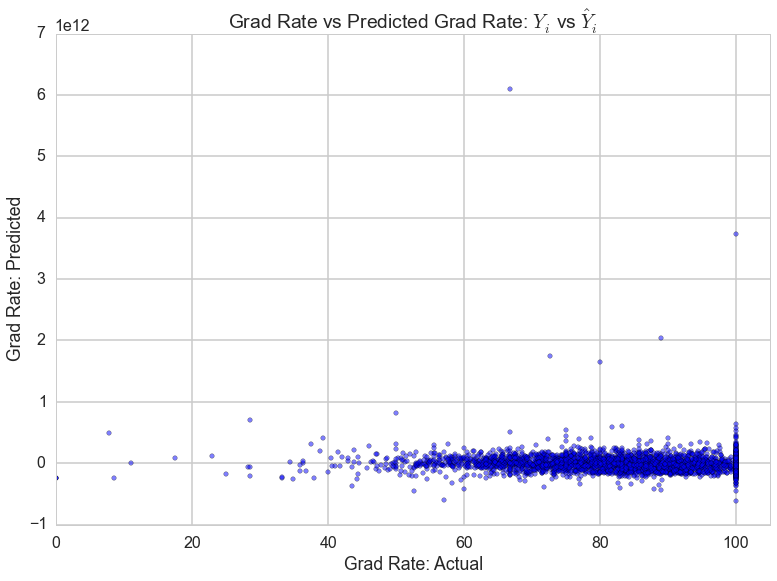

In [339]:
ypredict = lm.predict(Xtest)
rscore =  mean_squared_error(ytest, ypredict)
print "Mean Squared Error : ", rscore

plt.scatter(ytest, ypredict, alpha=0.5)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Grad Rate vs Predicted Grad Rate: $Y_i$ vs $\hat{Y}_i$")
plt.xlim(0,105)
#plt.ylim(0,105)
plt.show()    

##### Lasso Regression

In [340]:
lasso = linear_model.Lasso()

In [341]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [342]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:10]

,features,estimatedCoefficients
41,r_stud_re_W,1.496449
34,r_stud_912,1.148622
26,tlocrev_percent,0.842331
42,r_stud_re_Total,0.834020
51,r_stud_reg_12_W_M,0.542936
36,r_stud_re_F,0.033100
0,num_students,-0.000000
120,r_frev_ia,0.000000
113,r_frev_dis,0.000000
114,r_frev_cna,0.000000


In [343]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lasso.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:10]

,features,estimatedCoefficients
30,r_lunch_free,-3.016324
40,r_stud_re_B,-1.922189
25,tfedrev_percent,-0.671879
3,num_pub_schools,-0.114687
106,r_srev_gt,-0.036813
118,r_frev_ao,-0.034284
112,r_frev_title1,-0.000000
113,r_frev_dis,0.000000
114,r_frev_cna,0.000000
115,r_frev_ems,0.000000


In [344]:
from sklearn import cross_validation
cross_validation.cross_val_score(lasso, Xtrain, ytrain, scoring='r2')

array([ 0.3156014 ,  0.31176424,  0.31801381])

In [345]:
yp = lasso.predict(Xtest)
mean_squared_error(yp, ytest)

132.41102601659034

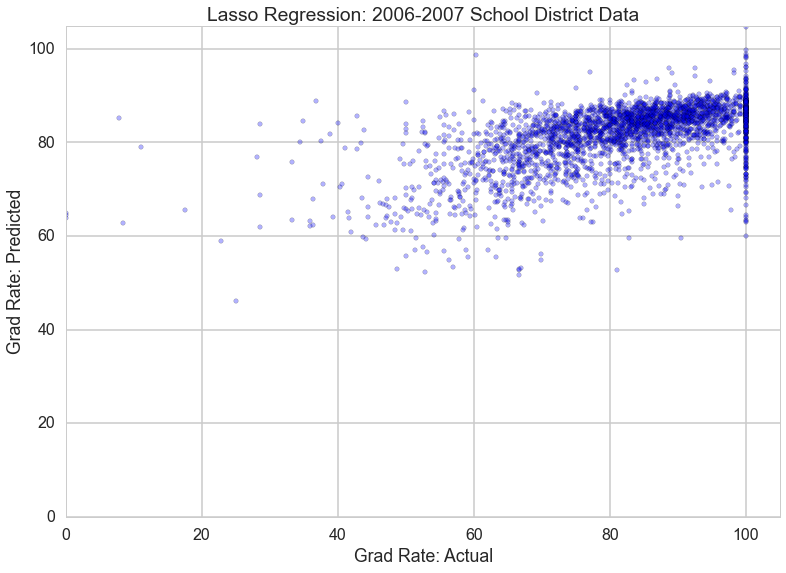

In [346]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Lasso Regression: 2006-2007 School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

##### Elastic Net

In [347]:
elasticnet = linear_model.ElasticNet()
elasticnet.fit(Xtrain, ytrain)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [348]:
pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=False)[:20]

,features,estimatedCoefficients
41,r_stud_re_W,1.292664
34,r_stud_912,1.060088
26,tlocrev_percent,0.816008
51,r_stud_reg_12_W_M,0.775423
42,r_stud_re_Total,0.608449
36,r_stud_re_F,0.346064
52,r_stud_reg_12_W_F,0.336655
76,r_lrev_pt,0.316851
38,r_stud_re_AAP,0.291935
4,tcuresal_percent,0.210040


In [349]:

pd.DataFrame(zip(dftouse0607[lcols].columns, elasticnet.coef_), columns = ['features', 'estimatedCoefficients']).sort(['estimatedCoefficients'], ascending=True)[:20]

,features,estimatedCoefficients
30,r_lunch_free,-1.886635
40,r_stud_re_B,-1.520982
25,tfedrev_percent,-0.921166
29,r_IEP,-0.331453
10,tfedrev_pp,-0.304889
106,r_srev_gt,-0.304483
118,r_frev_ao,-0.296672
3,num_pub_schools,-0.265479
28,r_ELL,-0.218137
1,num_schools,-0.210946


In [350]:
cross_validation.cross_val_score(elasticnet, Xtrain, ytrain, scoring='r2')

array([ 0.34497655,  0.32429677,  0.33163301])

In [351]:
yp = elasticnet.predict(Xtest)
mean_squared_error(yp, ytest)

127.56221558575209

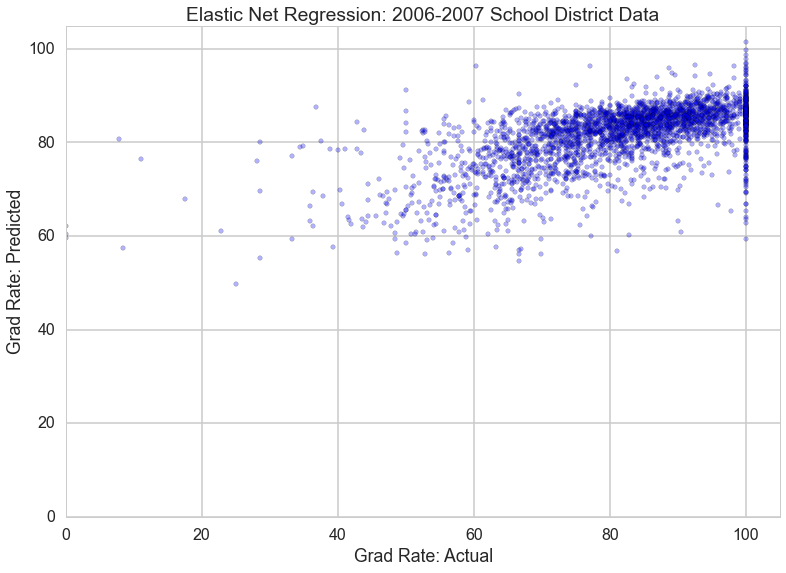

In [352]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Elastic Net Regression: 2006-2007 School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

### Creating a best model

Again, creating a best model based off of features that we learned from elastic net.

In [353]:
lcols=['r_stud_re_W','r_stud_912','r_stud_reg_12_W_M','tlocrev_percent','r_stud_re_Total','r_lunch_free','r_stud_re_B','tfedrev_percent','tfedrev_pp','r_frev_ao','r_stud_re_F','r_stud_reg_12_W_F','r_srev_gt','num_pub_schools']

In [354]:
Xmatrix=dftouse0607[lcols].values
Yresp=dftouse0607['afgr'].values

In [355]:
Xtrain=Xmatrix[mask]
Xtest=Xmatrix[~mask]
ytrain=Yresp[mask]
ytest=Yresp[~mask]

In [356]:
lm = linear_model.LinearRegression()
lm.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [357]:
print lm.intercept_
print lm.coef_

81.510436857
[ 1.11285622  1.70684375  1.15819179  1.70798608  1.15038508 -3.219141
 -2.52898564 -0.61038643 -0.38387926 -0.84810477  0.88431232 -0.34292184
 -0.84591516 -0.73519575]


In [358]:
pd.DataFrame(zip(dftouse0607[lcols].columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,r_stud_re_W,1.112856
1,r_stud_912,1.706844
2,r_stud_reg_12_W_M,1.158192
3,tlocrev_percent,1.707986
4,r_stud_re_Total,1.150385
5,r_lunch_free,-3.219141
6,r_stud_re_B,-2.528986
7,tfedrev_percent,-0.610386
8,tfedrev_pp,-0.383879
9,r_frev_ao,-0.848105


In [359]:
cross_validation.cross_val_score(lm, Xtrain, ytrain, scoring='r2')

array([ 0.37248643,  0.31631476,  0.32508989])

In [360]:
yp = lm.predict(Xtest)
mean_squared_error(yp, ytest)

127.02979473602149

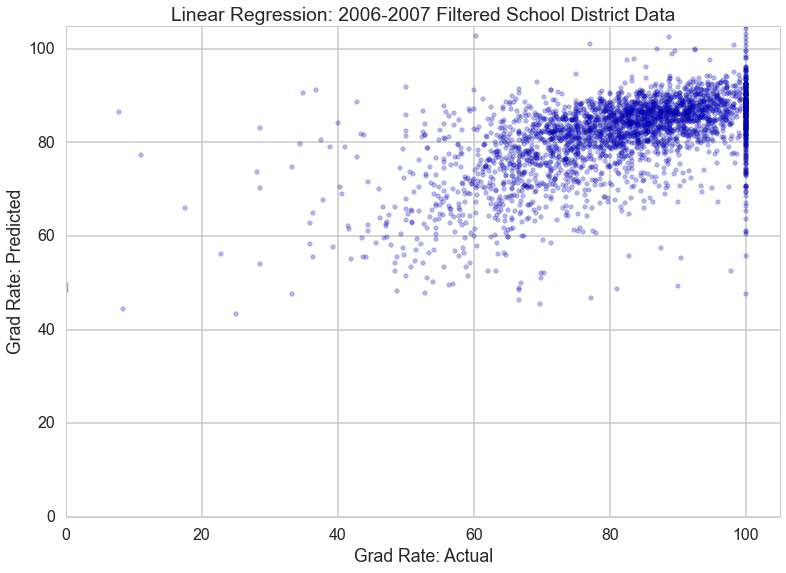

In [361]:
plt.scatter(ytest, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: 2006-2007 Filtered School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

### Predicting 2009-2010 graduation rate from 2006-2007 data.

We have our model of 2006-2007 graduation, and we try plugging in 2009-2010 data.  This is the scenario of having school district data available, but no graduation rates.

In [362]:
ActualX=dftouse[lcols].values
Actualy=dftouse['afgr'].values

In [363]:
yp = lm.predict(ActualX)
mean_squared_error(yp, Actualy)

133.91167388132399

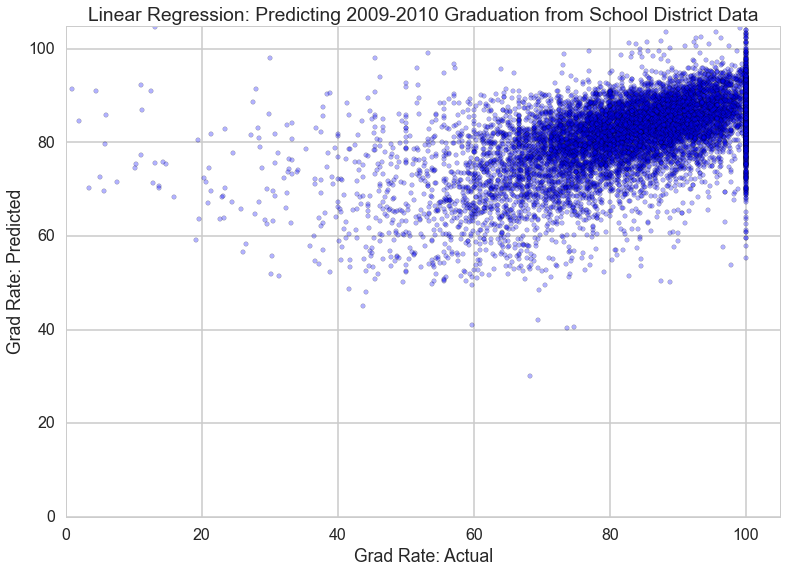

In [364]:
plt.scatter(Actualy, yp, alpha=.3)
plt.xlabel("Grad Rate: Actual")
plt.ylabel("Grad Rate: Predicted")
plt.title("Linear Regression: Predicting 2009-2010 Graduation from School District Data")
plt.xlim(0,105)
plt.ylim(0,105)
plt.show()   

The mean squared error is comparable to our earlier models.  Absent any available graduation rate data for 5 years, one could fill in the missing data using a predictive model until such graduation rate data becomes publically available.